<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
    
# Airbnb Price Determinants in Europe</div>
This dataset provides Airbnb rental information for major European cities, including Amsterdam, Rome, Paris, Vienna, Budapest, Berlin, London, and Lisbon. It features key attributes such as listing price, room type, host status (e.g., superhost), amenities, and location details. The data can be used to analyze factors influencing rental prices, helping travelers find affordable accommodations that meet their needs. It also offers valuable insights for hosts to set competitive prices and improve their listings to attract more bookings. Additionally, property investors can use this dataset to identify pricing trends and make informed decisions about real estate investments across Europe.

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">

### Dataset column profile:
| Column name       | Description                                           |
|-------------------|-------------------------------------------------------|
| realSum           | The total price of the Airbnb listing.      |
| room_type         | The type of room offered (e.g. private room, shared room, entire home/apt).|
| room_shared       | Whether the room is shared or not. 1 - True, 0 - False.           |
| room_private      | Whether the room is private or not. 1 - True, 0 - False.|
| person_capacity   | The maximum number of people that can be accommodated in a single listing. |
| host_is_superhost | Whether or not a particular host is identified as a superhost on Airbnb. 1 - Yes, 0 - No.|
| multi             | Whether multiple rooms are provided in one individual listing or not. 1 - Yes, 0 - No.|
| biz               | Whether a particular listing offers business facilities like meeting area/conference rooms in addition to accommodation options. 1 - Yes, 0 - No.|
| cleanliness_rating| The rating associated with how clean an individual property was after guests stayed at it. |
| guest_satisfaction_overall| The overall rating which shows how satisfied are guests with their stay after visiting an Airbnb property.|
| bedrooms          | The total quantity of bedrooms available among all properties against a single hosting id. |
| dist              | Distance from city centre associated with every rental property. (Measurement may vary depending upon scale eg kilometers/miles etc )|
| metro_dist         | Distance from metro station associated with every rental property. (Measurement may vary depending upon scale eg kilometers/miles etc )
| lng                | Longitude measurement corresponding to each rental unit.|
| lat                | Latitude measurement corresponding to each rental unit. |
| attr_index         | Represents the attraction index of the listing's location. It quantifies the proximity to and density of tourist attractions near the property.|
| attr_index_norm    | This is the normalized version of the attraction index, scaled between 0 and 100 for easier comparison across listings.|
| rest_index         | The restaurant index of the listing's location, indicating the concentration of dining options in the vicinity.|
| rest_index_norm    | This is the normalized restaurant index, with values ranging from 0 to 100, facilitating standardized comparisons between different areas.|


In [3]:
import os
import glob
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr, norm, shapiro, chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, StandardScaler

from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.filterwarnings('ignore')

<div style="color: #8B4513; font-weight: bold; font-size: 15px;">
### Data loading

In [5]:
# Load all files
file_list = glob.glob('/Users/alinagajdun/Documents/python for DA/data/Arbnb_price_data/*.csv')

# Load all files into a list of DataFrames
dataframe = [pd.read_csv(file) for file in file_list]

### Transforming and Cleaning Data 

In [7]:
# Create an empty list to store all tables
arbnb_data = []

# Function to transform and clean data
def transform_clean_data(file_list, bool_columns):
    """
    Transform and clean Airbnb data from a list of CSV files.

    This function reads a list of CSV files, extracts city names and day types from the file names,
    and performs the following operations:
        - Adds new columns: 'City' and 'day_of_week', extracted from the file name.
        - Reorders the columns, moving 'City' and 'day_of_week' to the front.
        - Converts boolean values (True/False) to integers (1/0) in the specified columns.
        - Drops the 'Unnamed: 0' column if it exists.
        - Appends the cleaned DataFrame to a global list `arbnb_data`.

    Parameters:
        file_list (list): List of file paths to the CSV files.
        bool_columns (list): List of column names that contain boolean values to be converted.

    Returns:
        None
    """
    for file in file_list:
        df = pd.read_csv(file)
       
         # Extract city name and day type from the file name
        filename = os.path.basename(file).split('.')[0]
        city, day_of_week = filename.split('_')

        # Add new columns: city and day_of_week
        df['City'] = city.capitalize()
        df['day_of_week'] = day_of_week.capitalize()

        # Columns to move
        columns_to_move = ['City', 'day_of_week']

        # Retain other columns
        remaining_columns = [col for col in df.columns if col not in columns_to_move]

        # Reorder columns
        new_column_order = columns_to_move + remaining_columns
        df = df[new_column_order]

        
        # Convert True/False values to 1/0 in specified columns
        for col in bool_columns:
            if col in df.columns:
                df[col] = df[col].astype(int)
            else:
                print(f'Column {col} not found in file {file}')
         
        # Drop the 'Unnamed: 0' column if it exists
        if 'Unnamed: 0' in df.columns:
            df.drop(columns=['Unnamed: 0'], inplace=True)

        # Append the cleaned DataFrame to the list
        arbnb_data.append(df)

In [8]:
# Apply the transformation and cleaning function
transform_clean_data(file_list, ['room_shared', 'room_private', 'host_is_superhost'])

# Combine all tables into one
arbnb_df = pd.concat(arbnb_data, ignore_index=True)

# Save the combined DataFrame to a file
arbnb_df.to_csv('arbnb_data.csv', index=False)
print('Combined data saved to "arbnb_data.csv"')

Combined data saved to "arbnb_data.csv"


In [9]:
# Load the updated DataFrame
df = pd.read_csv('/Users/alinagajdun/Documents/python for DA/data/Arbnb_price_data/arbnb_data.csv')

# Filter columns of type 'object' for optimization
filtered = df.select_dtypes(include='object')

# Extract unique categories and convert columns
for col in filtered.columns:
    unique_categories = df[col].unique()
    df[col] = pd.Categorical(df[col], categories=unique_categories, ordered=True)

# Check for duplicate rows
duplicate = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicate}\n')

# Check for missing values
missing = df.isnull().sum()
print(f'Missing values per column:\n{missing}')

Number of duplicate rows: 0

Missing values per column:
City                          0
day_of_week                   0
realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
dtype: int64


In [10]:
# Choose specify float columns to transform in int type
int_col = df[['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall']]

# Extract unique categories and convert columns
for col in int_col.columns:
    df[col] = df[col].astype('int')

In [11]:
# Apply float format for all float data
pd.options.display.float_format = "{:.3f}".format  # Display up to 3 decimal places
pd.options.display.max_columns = None  # Display all columns when outputting

# Output information about the DataFrame
print(df.info())
display(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   City                        51707 non-null  category
 1   day_of_week                 51707 non-null  category
 2   realSum                     51707 non-null  float64 
 3   room_type                   51707 non-null  category
 4   room_shared                 51707 non-null  int64   
 5   room_private                51707 non-null  int64   
 6   person_capacity             51707 non-null  int64   
 7   host_is_superhost           51707 non-null  int64   
 8   multi                       51707 non-null  int64   
 9   biz                         51707 non-null  int64   
 10  cleanliness_rating          51707 non-null  int64   
 11  guest_satisfaction_overall  51707 non-null  int64   
 12  bedrooms                    51707 non-null  int64   
 13  dist            

,City,day_of_week,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,Amsterdam,Weekdays,194.034,Private room,0,1,2,0,1,0,10,93,1,5.023,2.539,78.690,4.167,98.254,6.846,4.906,52.418
1,Amsterdam,Weekdays,344.246,Private room,0,1,4,0,0,0,8,85,1,0.488,0.239,631.176,33.421,837.281,58.343,4.900,52.374
2,Amsterdam,Weekdays,264.101,Private room,0,1,2,0,0,1,9,87,1,5.748,3.652,75.276,3.986,95.387,6.647,4.975,52.361


<div style="color: #8B4513; font-weight: bold; font-size: 18px;">
Transitioning to Dataset Analysis:  </div>
<div style="color: #8B4513; font-weight: bold; font-size: 14px;">
This step involves exploring and analyzing Airbnb rental data for major European cities, including Amsterdam, Rome, Paris, Vienna, Budapest, Berlin, London, and Lisbon.

The primary goals of this analysis are:
- To uncover patterns and trends in rental pricing across cities.
- To identify key factors influencing rental prices and guest satisfaction.
- To provide actionable insights for travelers seeking affordable accommodations and hosts looking to optimize their offerings.
  
By conducting this analysis, we aim to better understand the dynamics of the Airbnb rental market and derive meaningful conclusions to support decision-making.
</div>



<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
1. Conducting Feature Importance technique with a Forest of Trees to Identify Key Factors Influencing the Price (realSum)
</div>

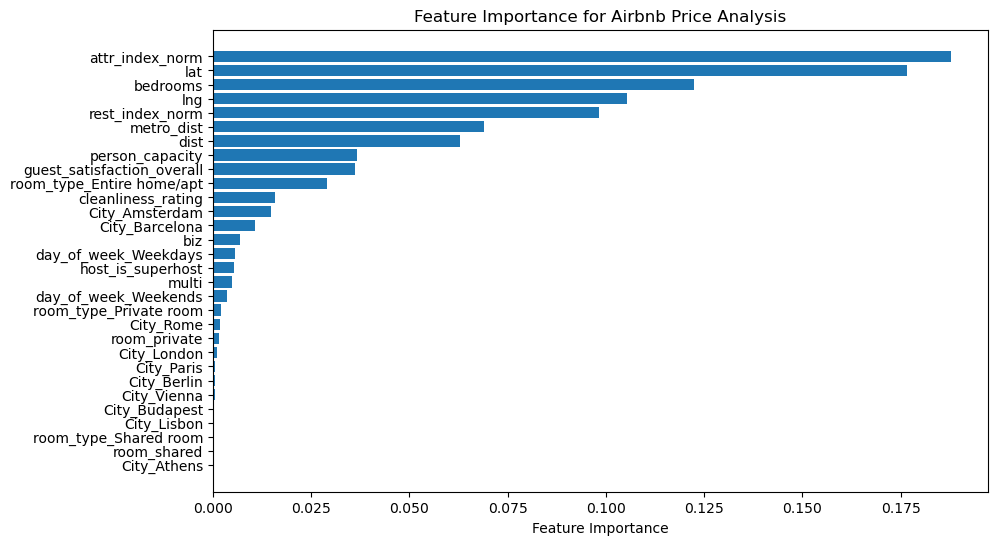

In [14]:
# Define features (X) and target variable (y)
X = df[['City', 'day_of_week', 'room_type', 'room_shared', 'room_private', 'person_capacity',
        'host_is_superhost', 'multi', 'biz', 'cleanliness_rating',
        'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'lng', 'lat',
        'rest_index_norm', 'attr_index_norm']]
y = df['realSum']

# Encode categorical features
X = pd.get_dummies(X)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=15)
model.fit(X_train, y_train)

# Calculate feature importance
feature_importance = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Airbnb Price Analysis')
plt.show();

<div style="color: #8B4513; font-weight: bold; font-size: 15px;">
The results of the Feature Importance analysis indicate that the most significant factors influencing rental prices are geographical attributes: distance to the city center (dist), coordinates (lat, lng), and proximity to metro stations (metro_dist). This is logical, as proximity to key locations greatly increases the attractiveness of the property for renters.

Another important factor is the number of bedrooms (bedrooms), which reflects the capacity of the accommodation and its convenience for group trips. Cleanliness ratings (cleanliness_rating) and guest satisfaction (guest_satisfaction_overall) also play a significant role in determining rental prices, emphasizing the importance of high-quality service to boost rental value.

Additionally, the normalized attraction index (attr_index_norm) and the normalized restaurant index (rest_index_norm) have notable influence on pricing, highlighting the importance of proximity to cultural landmarks and dining options for attracting tourists and increasing rental value.

In contrast, the day of the week (day_of_week) showed minimal influence on pricing, suggesting that there are no significant price fluctuations between weekdays and weekends. Similarly, the impact of cities included in the analysis was less significant compared to local geographical factors.

Next Steps: Further investigate other aspects of pricing to confirm or refute additional hypotheses, particularly in relation to tourist preferences and seasonal trends.</span>

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
2. What are the relationships between the most influential variables identified through Feature Importance analysis, and how do these variables correlate with each other?</div>

Correlation Matrix:



,dist,lng,lat,metro_dist,bedrooms,person_capacity,guest_satisfaction_overall,cleanliness_rating,rest_index_norm,attr_index_norm
dist,1.000,-0.147,0.406,0.558,-0.006,-0.128,-0.004,-0.030,-0.468,-0.243
lng,-0.147,1.000,-0.159,-0.070,0.014,0.147,0.156,0.120,-0.135,-0.222
lat,0.406,-0.159,1.000,0.086,-0.105,-0.168,-0.034,-0.093,0.024,0.435
metro_dist,0.558,-0.070,0.086,1.000,0.044,-0.037,0.030,0.010,-0.260,-0.220
bedrooms,-0.006,0.014,-0.105,0.044,1.000,0.561,0.048,0.033,-0.058,-0.064
person_capacity,-0.128,0.147,-0.168,-0.037,0.561,1.000,0.005,0.003,0.038,-0.050
guest_satisfaction_overall,-0.004,0.156,-0.034,0.030,0.048,0.005,1.000,0.714,-0.009,-0.074
cleanliness_rating,-0.030,0.120,-0.093,0.010,0.033,0.003,0.714,1.000,-0.006,-0.075
rest_index_norm,-0.468,-0.135,0.024,-0.260,-0.058,0.038,-0.009,-0.006,1.000,0.472
attr_index_norm,-0.243,-0.222,0.435,-0.220,-0.064,-0.050,-0.074,-0.075,0.472,1.000


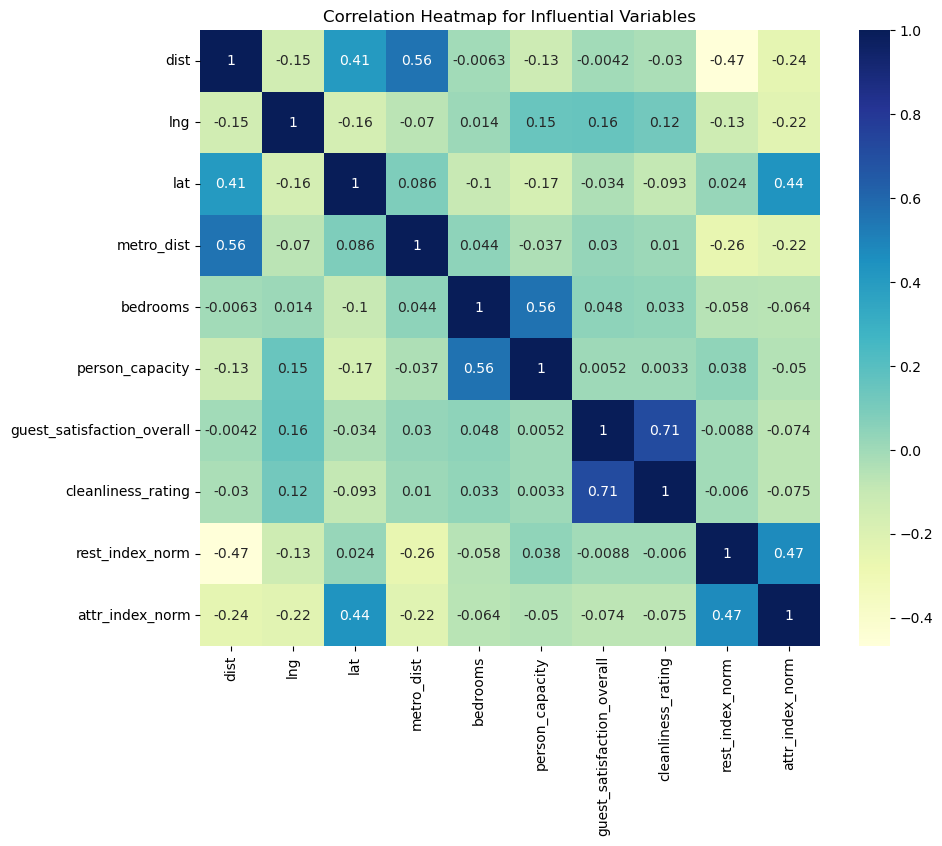

In [17]:
# Create a subset for the most influential variables
influential_variables_df = df[['dist', 'lng', 'lat', 'metro_dist', 'bedrooms',
                               'person_capacity', 'guest_satisfaction_overall',
                               'cleanliness_rating', 'rest_index_norm', 'attr_index_norm']]

# Calculate the correlation matrix
correlation_matrix = influential_variables_df.corr(method='pearson')
print('Correlation Matrix:\n')
display(correlation_matrix)

# Plot the correlation heatmap
plt.figure(figsize=(10,8))
dataplot = sns.heatmap(correlation_matrix, cmap='YlGnBu', annot=True)
plt.title('Correlation Heatmap for Influential Variables')
plt.show();

<div style="color: #8B4513; font-weight: bold; font-size: 15px;">

According to the correlation matrix, a relatively strong relationship between the variables cleanliness_rating and guest_satisfaction_overall indicates that the cleanliness of the property has a noticeable impact on guest satisfaction levels. The moderate correlation between person_capacity and bedrooms is also logical, as a larger number of bedrooms typically ensures greater capacity. Additionally, the distance to the metro and the city center shows a moderate correlation. The remaining variables, which have shown an impact on realSum, do not correlate with each other.

We will now build a scatterplot between cleanliness_rating and guest_satisfaction_overall to visualize the form of their relationship.</div>

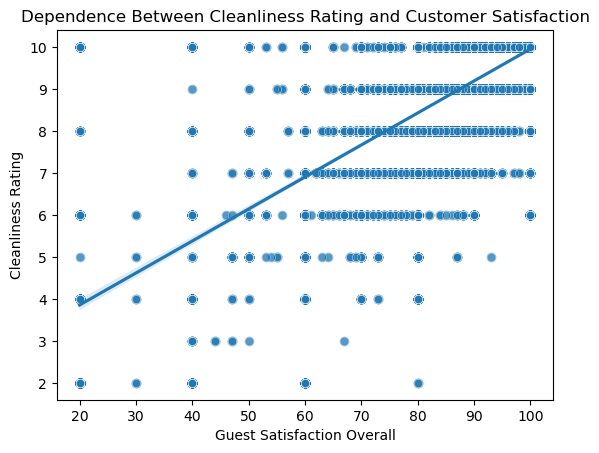

In [19]:
#Scatterplot to determine the relationship between guest satisfaction and cleanliness rating
sns.regplot(x='guest_satisfaction_overall', y='cleanliness_rating', data=df, scatter_kws={'alpha': 0.5})
sns.scatterplot(x=df['guest_satisfaction_overall'], y=df['cleanliness_rating'], alpha=0.5)
plt.title('Dependence Between Cleanliness Rating and Customer Satisfaction')
plt.xlabel('Guest Satisfaction Overall')
plt.ylabel('Cleanliness Rating')
plt.show();

In [20]:
# Test the significance of the correlation using Pearson's test
corr, p_value = pearsonr(df['cleanliness_rating'], df['guest_satisfaction_overall'])

print(f'Correlation: {corr}, p-value: {p_value}')

alpha = 0.05

if p_value < alpha:
    print('Statistically significant result.')
else:
    print('No statistical significance.')

Correlation: 0.7140450220819937, p-value: 0.0
Statistically significant result.


<div style="color: #8B4513; font-weight: bold; font-size: 18px;">
Conclusions: </div>
<div style="color: #8B4513; font-size: 15px;">
There is a strong positive correlation (0.714) between cleanliness_rating and guest_satisfaction_overall, indicating a linear relationship: the higher the cleanliness rating, the greater the overall guest satisfaction.

The p-value = 0.0 confirms that the correlation is statistically significant. The null hypothesis of no correlation is rejected. This finding provides high confidence that a genuine relationship exists between these variables in the analyzed dataset.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 18px;">
Recommendations:</div>
<div style="color: #8B4513; font-size: 15px;">
Landlords should pay close attention to the cleanliness of their properties, as guest satisfaction is directly proportional to cleanliness. This, in turn, impacts the host’s ratings and potential future bookings.

It is recommended to:
1. Ensure the property is cleaned thoroughly before guest check-in.
2. Offer weekly cleaning services to maintain the property in good condition during longer stays.
By prioritizing cleanliness, landlords can enhance guest satisfaction and improve their ratings on platforms like Airbnb.</div>

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
3. Average Rental Prices Across Cities on Weekdays and Weekends: Are There Significant Differences?</div>

In [23]:
# Create a pivot table showing average rental prices across cities on weekdays and weekends
day_of_week_pivot = pd.pivot_table(
    df,
    index='City',
    columns='day_of_week',
    values='realSum',
    aggfunc='mean',
)

# Sort by the column representing weekdays
day_of_week_pivot = day_of_week_pivot.sort_values(by='Weekdays', ascending=False)

# Display the result with a background gradient for better visualization
display(day_of_week_pivot.style.background_gradient(cmap='YlGnBu', axis=1))

day_of_week,Weekdays,Weekends
City,,
Amsterdam,545.020526,604.828018
Paris,398.786678,387.028589
London,360.230348,364.389747
Barcelona,288.391667,300.277940
Vienna,240.384834,242.739524
Berlin,240.220422,249.252516
Lisbon,236.345459,240.044051
Rome,201.618053,209.130063
Budapest,168.429367,185.120628


<div style="color: #8B4513; font-weight: bold; font-size: 15px;">
We will conduct a Two-Way ANOVA test to assess the significance of differences in average rental prices across cities on weekdays and weekends. Specifically, we aim to determine:</div>

<div style="color: #8B4513; font-size: 15px;">
    
- Whether each factor independently affects the outcome.
- Whether there is an interaction between these factors.</div>

<div style="color: #8B4513; font-weight: bold; font-size: 15px;">
Hypotheses for Two-Way ANOVA:</div>

<div style="color: #8B4513; font-size: 15px;">
    
1. Main Effects of Factors:
H₀ (Null Hypothesis): Average prices do not depend on the city.
H₀ (Null Hypothesis): Average prices do not depend on the day of the week.
2. Interaction of Factors:
H₀ (Null Hypothesis): There is no interaction between cities and days of the week (the effect of one factor is independent of the other).

#### Before conducting the ANOVA test, we will check the sample for normality of distribution. </div>

In [25]:
# Create a function that check columns for normality of distribution
def check_normality_for_columns(df, columns):
    """
    Checks the normality of distributions for a list of columns using the Shapiro-Wilk test.
    Visualizes each distribution with a histogram and normal distribution curve.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): List of column names to check for normality.

    Returns:
    dict: A dictionary with column names as keys and a tuple of test statistics,
          p-values, and normality result (True if normal, False otherwise) as values.
    """
    results = {}

    for column in columns:
        data = df[column]  # Drop missing values for accurate testing
        mean, std = norm.fit(data)  # Fit data to normal distribution

        # Create x-axis for the normal distribution plot
        x_axis = np.linspace(data.min(), data.max(), 100)

        # Plot histogram and normal distribution curve
        plt.figure(figsize=(8, 5))
        plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data histogram')
        plt.plot(x_axis, norm.pdf(x_axis, mean, std), 'r', lw=2, label='Normal PDF')

        # Perform Shapiro-Wilk test
        stat, p_value = shapiro(data)

        # Title and labels
        plt.title(f'Distribution of {column} (p-value={p_value:.4f})')
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Determine if the distribution is normal
        is_normal = p_value >= 0.05

        # Store the results
        results[column] = (stat, p_value, is_normal)

        # Print the results
        print(f'Column: {column}')
        print(f'Test Statistic: {stat}')
        print(f'p-value: {p_value}')
        print(f'Is Normal: {'Yes' if is_normal else 'No'}\n')

    return results


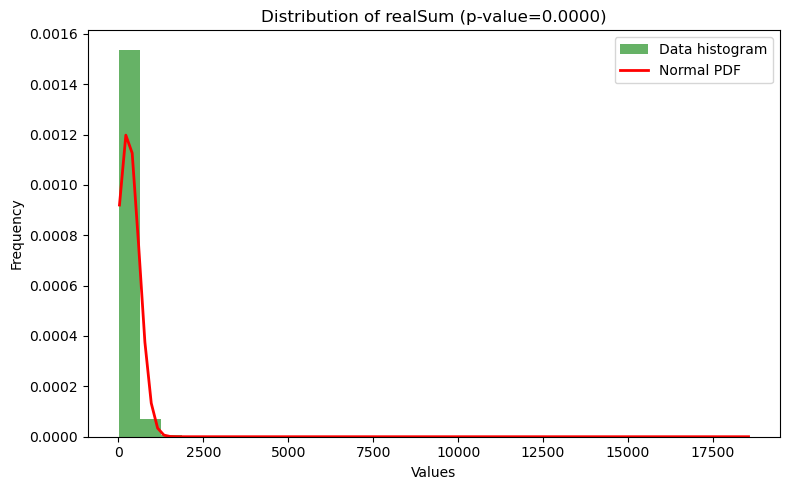

Column: realSum
Test Statistic: 0.37040095953699226
p-value: 6.758722626837969e-150
Is Normal: No



{'realSum': (0.37040095953699226, 6.758722626837969e-150, False)}

In [26]:
# Apply check normality function
colum_to_check = ['realSum']
check_normality_for_columns(df,colum_to_check)

In [27]:
def log_transform(df, cols):
    """
    Apply logarithmic transformation to specified columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    cols (list): List of column names to transform.

    Returns:
    pd.DataFrame: DataFrame with log-transformed columns.
    """
    log_transformed = df.copy()
    
    for col in cols:
        # Create a copy of the column for transformation
        if col in log_transformed.columns:
            if (log_transformed[col] > 0).all():
                log_transformed[col] = np.log(log_transformed[col])
                print(f"Logarithmic transformation applied to column: {col}")
            else:
                print(f"Skipped column {col} due to zero or negative values.")
        else:
            print(f"Column {col} not found in the DataFrame.")

    return log_transformed

Logarithmic transformation applied to column: realSum


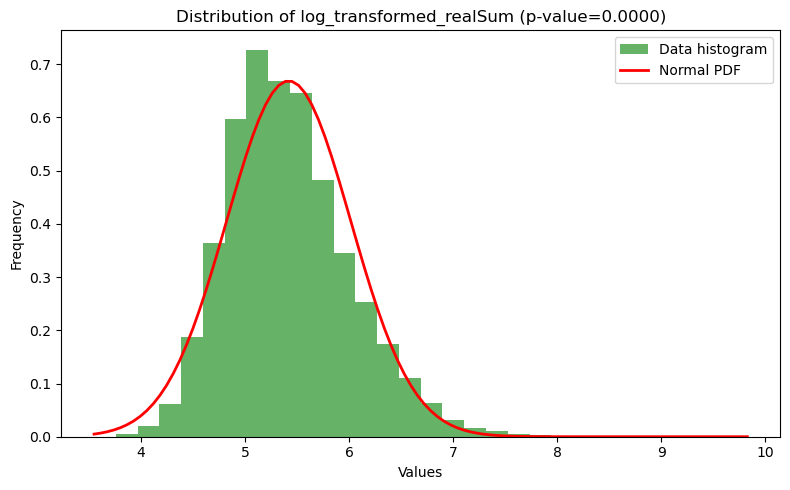

Column: log_transformed_realSum
Test Statistic: 0.9751866702851335
p-value: 1.1171854676413117e-65
Is Normal: No



{'log_transformed_realSum': (0.9751866702851335,
  1.1171854676413117e-65,
  False)}

In [28]:
# Apply log transformation to specific columns
df['log_transformed_realSum'] = log_transform(df, ['realSum'])['realSum']

# Apply check normality function
columns_to_check = ['log_transformed_realSum']
check_normality_for_columns(df, columns_to_check)

In [29]:
# Try to apply Yeo-Johnson trasformation
transformer = PowerTransformer(method='yeo-johnson')
df['transformed_col'] = transformer.fit_transform(df[['realSum']])

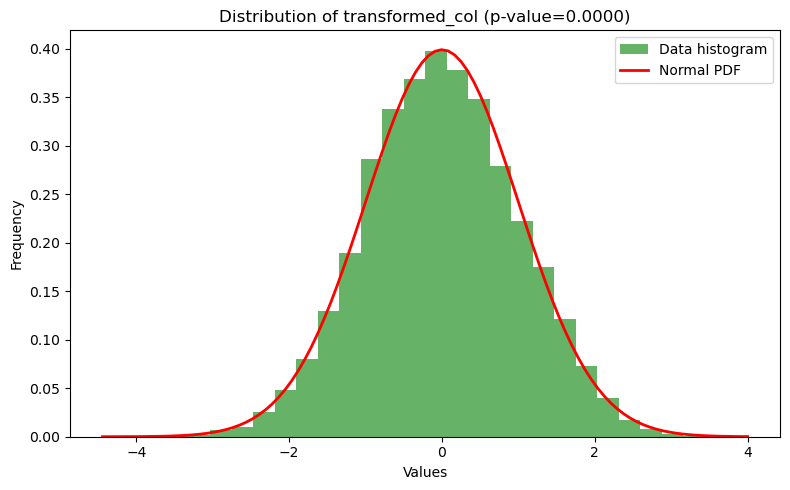

Column: transformed_col
Test Statistic: 0.9996220457625294
p-value: 2.3234059578301577e-08
Is Normal: No



{'transformed_col': (0.9996220457625294, 2.3234059578301577e-08, False)}

In [30]:
# Apply check normality function
colum_to_check = ['transformed_col']
check_normality_for_columns(df,colum_to_check)

<div style="color: #8B4513; font-weight: bold; font-size: 15px;">
Since it was not possible to transform the realSum column to a normal distribution using two different methods, we will proceed with a non-parametric test Permutation ANOVA.</div>

In [32]:
def permutation_anova(data, dv, between, n_permutations=10000):
    """
    Performs a permutation ANOVA to test the significance of differences between groups.
    
    Parameters:
    :param data: DataFrame with data
    :param dv: Column name of dependent variable (e.g. 'realSum')
    :param between: Column name of factor variable (e.g. 'day_type' or 'City')
    :param n_permutations: Number of permutations (default 10000)
    :return: p-value for permutation ANOVA
    """
    
    # Create list of unique groups
    unique_groups = data[between].unique()
    
    # Check if there are at least 2 groups
    if len(unique_groups) < 2:
        raise ValueError("There must be at least two unique groups for comparison.")
    
    # Create a list of data for each group
    group_data = [data[data[between] == group][dv].values for group in unique_groups]
    
    # We calculate the original F-statistic for the data
    f_stat, _ = stats.f_oneway(*group_data)
    
    # List for saving permutation results
    permutation_stats = []
    
    # Permutation process
    for _ in range(n_permutations):
        # Combine all values ​​and mix
        combined_data = np.concatenate(group_data)
        np.random.shuffle(combined_data)
        
        # Distribute the moved values ​​back into groups
        permuted_group_data = [
            combined_data[i: i + len(group)]
            for i, group in zip(
            np.cumsum([0] + [len(g) for g in group_data[:-1]]), 
            group_data
            )
        ]
        
        # Calculating the F-statistic for permuted data
        perm_f_stat, _ = stats.f_oneway(*permuted_group_data)
        permutation_stats.append(perm_f_stat)
    
    # P-value estimation
    p_value = np.sum(np.array(permutation_stats) >= f_stat) / n_permutations
    
    return p_value

In [33]:
# Get the unique cities from the 'City' column
cities = df['City'].unique()

# Loop through each city to perform permutation ANOVA for each one
for city in cities:
    # Filter the data for the current city
    city_data = df[df['City'] == city]
    
    # Call the permutation_anova function to calculate the p-value for the current city
    # The function takes City data, 'realSum' as the dependent variable, and 'day_type' as the factor
    p_value = permutation_anova(city_data, dv='realSum', between='day_of_week', n_permutations=10000)
    
    print(f"City: {city}, p-value: {p_value}")

City: Amsterdam, p-value: 0.0013
City: Barcelona, p-value: 0.3932
City: Rome, p-value: 0.0018
City: Berlin, p-value: 0.3522
City: Budapest, p-value: 0.0
City: Vienna, p-value: 0.9462
City: London, p-value: 0.6606
City: Lisbon, p-value: 0.1974
City: Athens, p-value: 0.2813
City: Paris, p-value: 0.15


<div style="color: #8B4513; font-weight: bold; font-size: 18px;">
Conclusions: </div>
<div style="color: #8B4513; font-size: 16px;">
Significant differences in rental prices between weekdays and weekends in cities like Amsterdam, Rome, and Budapest are likely driven by special events, festivals, and increased weekend tourism. These events lead to higher demand and higher prices. In contrast, cities like Vienna, London, and Lisbon show no such differences, possibly due to a more consistent flow of visitors or standardized pricing models. Overall, events and festivals are key factors driving weekend price fluctuations in high-tourism cities.</div>

<div style="color: #8B4513; font-weight: bold; font-size: 18px;">
Recommendations based on the analysis:</div>
<div style="color: #8B4513; font-size: 16px;">
	
1. Adjust Prices for Weekends in High-Demand Cities: In cities like Amsterdam, Rome, and Budapest, where significant price differences exist between weekdays and weekends, owners should increase prices during weekends to capitalize on higher demand due to events and festivals.
2. Offer Special Packages for Tourists: Property owners in high-tourism cities should create special packages or discounts for weekend visitors attending events, festivals, or seasonal activities, enhancing guest attraction and occupancy rates.
3. Implement Dynamic Pricing: Use dynamic pricing strategies to automatically adjust rental prices based on demand, raising prices during peak times like weekends and lowering them during weekdays to maintain steady occupancy.
4. Target Weekdays with Promotions: To boost weekday bookings, owners can offer special deals or discounts, ensuring a consistent income stream even when demand is lower compared to weekends. </div>

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
4. Does the host’s status (host_is_superhost) affect the type of accommodation they offer (room_type)?</div>
<div style="color: #8B4513; font-size: 15px;">
To answer this question, I will use a contingency analysis (contingency table with a chi-square test) to check for statistical dependence.</div>

In [36]:
# Function to create and analyze the contingency table for any pair of columns
def cross_table(df, col1, col2):
    """
    Create and analyze a contingency table between two specified columns.
    
    Parameters:
    df (DataFrame): The dataset to analyze.
    col1 (str): The name of the first column.
    col2 (str): The name of the second column.
    
    Returns:
    chi2, p, dof, expected, contingency_table: tuple containing the chi-square statistic, p-value, degrees of freedom,
    expected frequencies, and the contingency table.
    """
    # Create the contingency table for the two specified columns
    contingency_table = pd.crosstab(df[col1], df[col2])
    
    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Return results as a tuple
    expected_df = pd.DataFrame(
            expected, 
            index=contingency_table.index, 
            columns=contingency_table.columns
    )
    
    return chi2, p, dof, expected_df, contingency_table

In [37]:
# Apply function to create a conjugation table
chi2, p_value, dof, expected, contingency_table = cross_table(df, 'room_type', 'host_is_superhost')

# Display results
print('Chi2 Statistic:', chi2)
print('p-value:', p_value)
print('Degrees of Freedom:', dof)
print('Expected Frequencies:')
display(expected)

Chi2 Statistic: 176.54066965543066
p-value: 4.620411632426391e-39
Degrees of Freedom: 2
Expected Frequencies:


host_is_superhost,0,1
room_type,,
Private room,13909.397,4783.603
Entire home/apt,24293.264,8354.736
Shared room,272.339,93.661


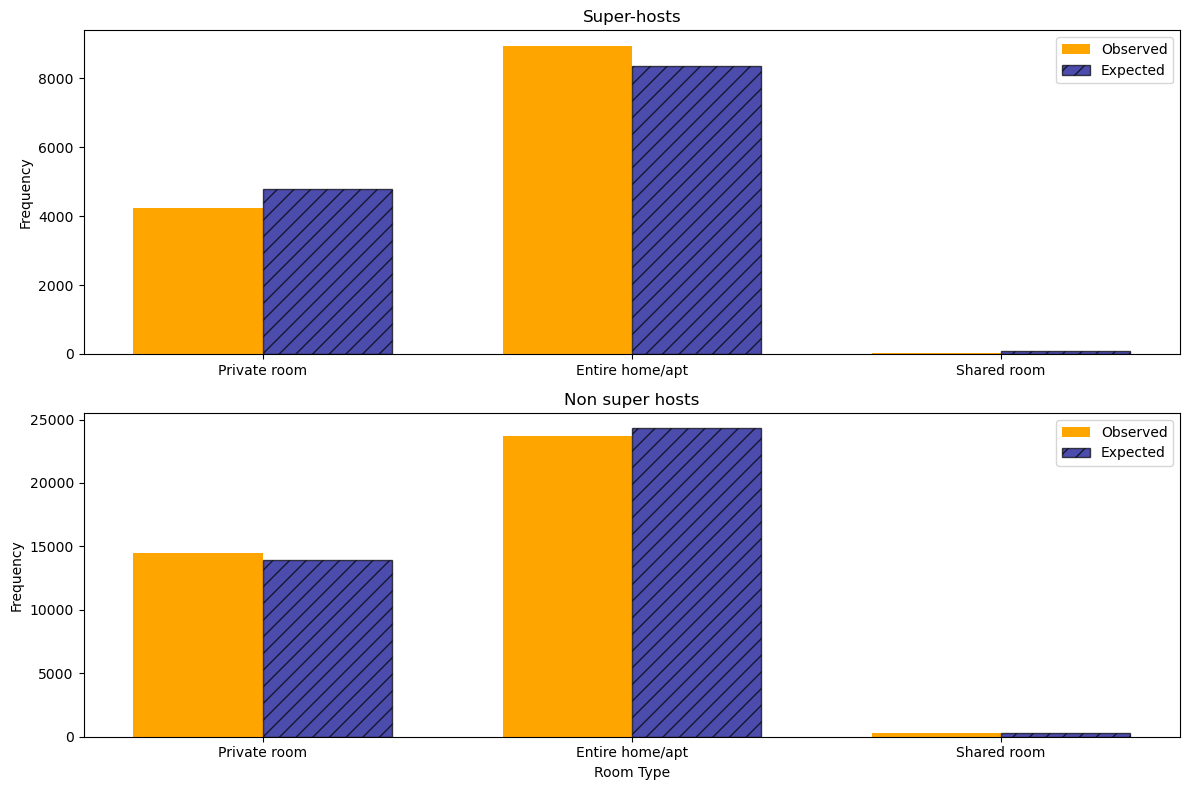

In [38]:
# Table of observed and expected frequencies
observed = contingency_table
expected = pd.DataFrame(
    expected, 
    index=contingency_table.index, 
    columns=contingency_table.columns
)

# Column positions
x = np.arange(len(observed.index))
bar_width = 0.35  # Column width

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # Two subplots vertically

# Subplot for super hosts
axes[0].bar(
    x - bar_width / 2,
    observed[1],
    bar_width,
    label='Observed',
    color='orange',
)
axes[0].bar(
    x + bar_width / 2,
    expected[1],
    bar_width,
    label='Expected',
    color='darkblue',
    edgecolor='black',
    hatch='//',
    alpha=0.7,
)
axes[0].set_title('Super-hosts')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(x)
axes[0].set_xticklabels(observed.index)
axes[0].legend()

# Subplot for non super hosts
axes[1].bar(
    x - bar_width / 2, 
    observed[0], 
    bar_width, 
    label='Observed', 
    color='orange'
)
axes[1].bar(
    x + bar_width / 2, 
    expected[0], 
    bar_width, 
    label='Expected', 
    color='darkblue', 
    edgecolor='black', 
    hatch='//', 
    alpha=0.7)
axes[1].set_title('Non super hosts')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Room Type')
axes[1].set_xticks(x)
axes[1].set_xticklabels(observed.index)
axes[1].legend()

# Show plot
plt.tight_layout()
plt.show();

<div style="color: #8B4513; font-weight: bold; font-size: 18px;">
Conclusion:</div>
<div style="color: #8B4513; font-size: 16px;">
Based on the conducted χ²-test and the contingency table analysis, we can conclude that there is a relationship between the type of accommodation (room_type) and the host’s status (host_is_superhost). Since the p-value is 4.62e-39, which is extremely small and much less than 0.05, we reject the null hypothesis of independence between the variables and confirm statistical significance. Regarding the observed and expected frequencies for the accommodation types, it is evident that super hosts tend to offer “Entire home/apartment” more frequently than expected, which likely contributes to their ratings and super host status. On the other hand, regular hosts tend to offer “Private room” more than expected, likely due to the availability and maintenance of such properties. “Shared room” is rarely offered by super hosts, even less frequently than expected. In my opinion, “Shared room” accommodations are generally preferred by budget tourists, and their high turnover can make it difficult to maintain the property in optimal condition. </div>

<div style="color: #8B4513; font-weight: bold; font-size: 18px;">Business Insights:</div>
<div style="color: #8B4513; font-size: 16px;">
    
1. Popularity of Entire Home/Apt among Super hosts:
- Super hosts likely focus more on offering comfortable, independent accommodations. This is supported by the fact that “Entire Home/Apt” is the most common type of property among super hosts.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Recommendation: Airbnb could emphasize the expansion or optimization of “Entire Home/Apt” offerings for super hosts, as it aligns well with their status.</div>
<div style="color: #8B4513;font-size: 16px;">
    
2. Private Room is Less Popular Among Super hosts:
- “Private Room” is more frequently offered by non-super hosts. This may be due to lower investment or less effort required to maintain high quality for this type of accommodation.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Recommendation: Airbnb could introduce support programs for hosts offering “Private Room” with a focus on improving service quality. This could help them achieve super host status.</div>

<div style="color: #8B4513; font-size: 16px;">
    
3. Shared Room is Almost Absent Among Super hosts:
- The low frequency of “Shared Room” offerings by super hosts might indicate low demand or the challenges of maintaining super host standards for this type of accommodation.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Recommendation: Airbnb could reconsider its strategy regarding “Shared Room.” For example, they could create tools to increase the attractiveness of this accommodation type or develop special offers for hosts looking to improve service quality in this category. </div>

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
5. Let’s investigate the frequency of selection for each room_type. </div>

In [41]:
# Calculate the frequency of selection for each room type
frequency_room_type = df['room_type'].value_counts()

# Calculate the percentage frequency for each room type
frequency_room_type_percentage = df['room_type'].value_counts(normalize=True) * 100

# Print the frequency of each room type
print(f'Frequency of selection of each room_type:\n{frequency_room_type}\n')

# Print the percentage frequency of each room type
print(f'Frequency of choice in percentage:\n{frequency_room_type_percentage}')

Frequency of selection of each room_type:
Entire home/apt    32648
Private room       18693
Shared room          366
Name: room_type, dtype: int64

Frequency of choice in percentage:
Entire home/apt   63.140
Private room      36.152
Shared room        0.708
Name: room_type, dtype: float64


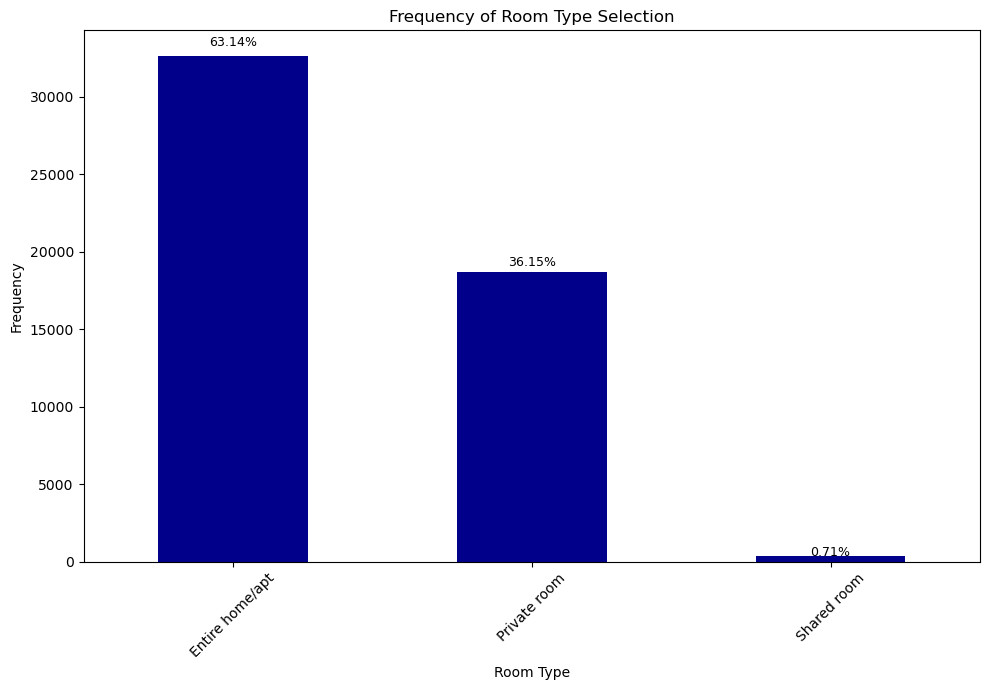

In [42]:
# Plot the frequency distribution of room type choices
plt.figure(figsize=(10, 7))
frequency_room_type.plot.bar(color='darkblue')
plt.title('Frequency of Room Type Selection')
plt.xlabel('Room Type')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

# Add percentages on top of the bars
for i, value in enumerate(frequency_room_type):
    percent = f'{frequency_room_type_percentage.iloc[i]:.2f}%'  # Take percentage value for each bar
    plt.text(i, value + value * 0.02, percent, ha='center', fontsize=9, color='black')  # Text slightly above the bar

# Display the plot
plt.tight_layout()
plt.show();

<div style="color: #8B4513; font-weight: bold; font-size: 18px;">
Conclusion:</div>
<div style="color: #8B4513; font-size: 16px;">
The most popular type of accommodation is Entire Home/Apt, which accounts for the largest share of guest selections (63.14%). Shared Room is the least popular (0.71%), which may indicate low demand or specific market characteristics.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 18px;">
Recommendations:</div>
<div style="color: #8B4513; font-size: 16px;">
Owners of Entire Home/Apt properties should focus on maintaining high quality and ratings of their accommodations to sustain their attractiveness to renters. To increase demand for Shared Room accommodations, special offers could be introduced, such as promotions like “Book 2 nights, get the 3rd night free,” to attract renters and generate demand in the budget accommodation segment.</div>

<div style="color: #8B4513; font-weight: bold; font-size: 18px;">
6. Is there a relationship between the choice of room_type and geographical factors (proximity to the city center, latitude, longitude, proximity to the metro, distance to attractions)?</div>

In [45]:
# Do Chi2 - analyze
# Create categories for various geographic and index-based columns
df['lng_category'] = pd.cut(
    df['lng'], 
    bins=4, 
    labels=['West', 'Mid-West', 'Mid-East', 'East']
)
df['lat_category'] = pd.cut(
    df['lat'], 
    bins=4, 
    labels=['South', 'Mid-South', 'Mid-North', 'North']
)
df['dist_category'] = pd.cut(
    df['dist'], 
    bins=[0, 2, 5, 10, np.inf], 
    labels=['Very Close', 'Close', 'Medium', 'Far']
)
df['metro_dist_category'] = pd.cut(
    df['metro_dist'], 
    bins=[0, 1, 3, 5, np.inf], 
    labels=['Very Close', 'Close', 'Medium', 'Far']
)
df['rest_index_norm_category'] = pd.qcut(
    df['rest_index_norm'], 
    q=4, 
    labels=['Very Close', 'Close', 'Medium', 'Far']   # Divide by quartiles
)  
df['attr_index_norm_category'] = pd.qcut(
    df['attr_index_norm'], 
    q=4, 
    labels=['Very Close', 'Close', 'Medium', 'Far']  # Divide by quartiles
)

# Apply function to every specific columns in df
col2 = ['dist', 'metro_dist', 'lng', 'lat', 'rest_index_norm', 'attr_index_norm']
for col in col2:
    chi2, p_value, dof, expected_df, contingency_table = cross_table(df, 'room_type', col)
    
    # Print results
    print(f'\nContingency table for room_type and {col}:')
    print('Chi2 Statistic:', chi2)
    print('p-value:', p_value)
    print('Degrees of Freedom:', dof)


Contingency table for room_type and dist:
Chi2 Statistic: 103414.0
p-value: 0.49766076626414846
Degrees of Freedom: 103412

Contingency table for room_type and metro_dist:
Chi2 Statistic: 103413.99999999997
p-value: 0.497660766264174
Degrees of Freedom: 103412

Contingency table for room_type and lng:
Chi2 Statistic: 82439.90916078979
p-value: 0.0
Degrees of Freedom: 47198

Contingency table for room_type and lat:
Chi2 Statistic: 79307.16153240643
p-value: 0.0
Degrees of Freedom: 42966

Contingency table for room_type and rest_index_norm:
Chi2 Statistic: 103392.46805431097
p-value: 0.4832174400023197
Degrees of Freedom: 103374

Contingency table for room_type and attr_index_norm:
Chi2 Statistic: 103400.08035834244
p-value: 0.4765480642166391
Degrees of Freedom: 103374


<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Since statistical significance is confirmed only for the latitude and longitude indicators (lat and lng), and their high Chi2 statistics (82439.91 for lng and 79307.16 for lat) indicate that observed frequencies significantly differ from expected ones, this highlights the importance of geographical factors in the choice of housing type. Further analysis will be conducted for these indicators. </div>

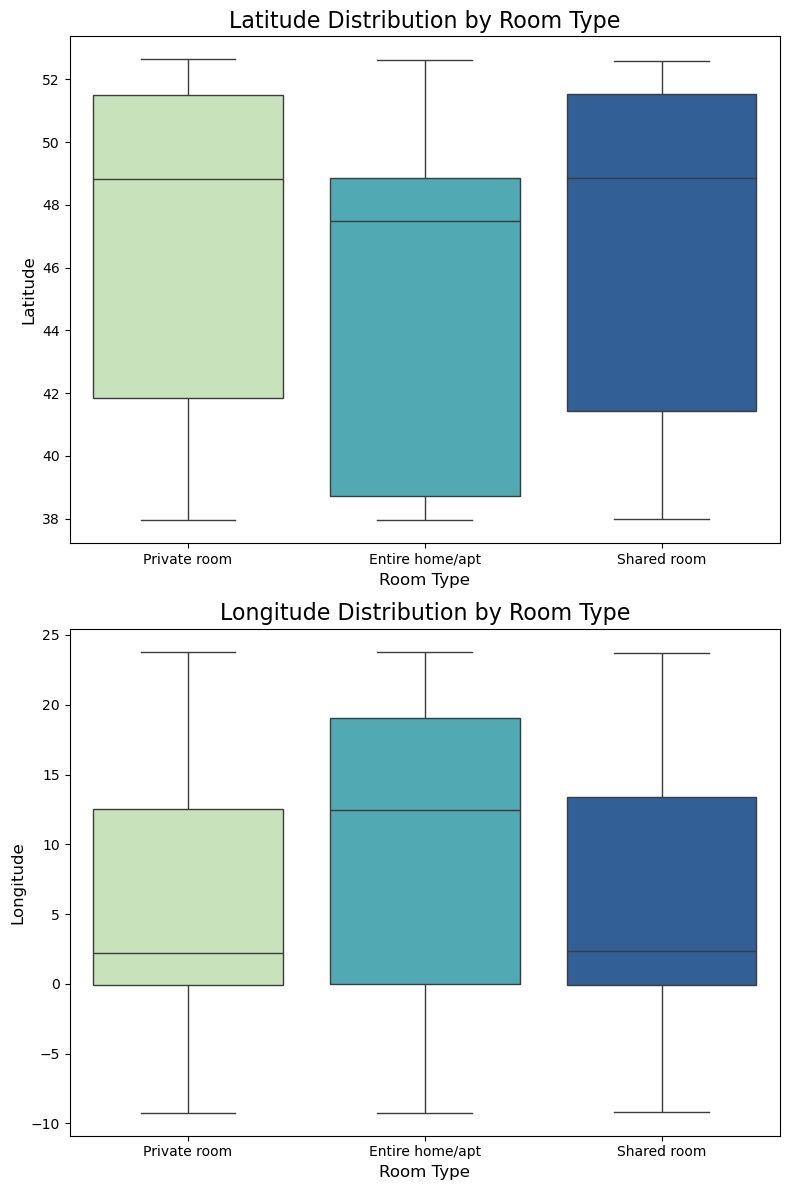

In [47]:
# Build visualization for latitude and longitude indicators
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Boxplot for latitude
sns.boxplot(data=df, x='room_type', y='lat', palette='YlGnBu', ax=axes[0])
axes[0].set_xlabel('Room Type', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)

# Boxplot for longitude
sns.boxplot(data=df, x='room_type', y='lng', palette='YlGnBu', ax=axes[1])
axes[1].set_xlabel('Room Type', fontsize=12)
axes[1].set_ylabel('Longitude', fontsize=12)

# Set titles
axes[0].set_title('Latitude Distribution by Room Type', fontsize=16)
axes[1].set_title('Longitude Distribution by Room Type', fontsize=16)

plt.tight_layout()
plt.show();

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
The latitude distribution for Private room and Shared room ranges from 41 to 51, with an average of 49, while the range for Entire home/apartment is between 39 and 49, with an average of 47.5. In terms of longitude, Entire home/apartment has a larger spread compared to the other room types, ranging from 0 to 19, with an average of 12.5. On the other hand, Private room and Shared room have average longitudes of 2 to 2.5, and their range is one-third smaller.

From this, we can conclude that when choosing accommodation types, there is more leniency towards geographical factors for Entire home/apartment. I might assume that this is related to the income level of the renters, and they are less concerned about geographical location, as they can use taxis or rental cars to travel from point A to point B. However, renters of Private room and Shared room are more likely to impose specific geographical location restrictions on their future rental accommodation, likely due to the convenience of access to certain landmarks. These renters may have a lower budget and rely more on public transportation or walking distance.
</div>

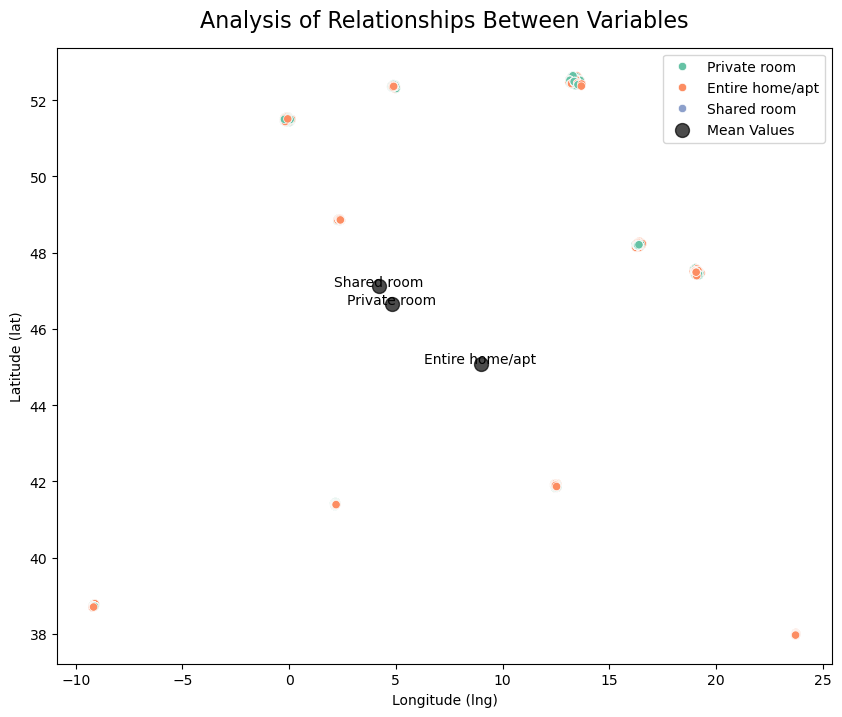

In [49]:
# Calculate the mean values
mean_values = df.groupby('room_type')[['lng', 'lat']].mean().reset_index()

plt.figure(figsize=(10, 8))

# Create the main scatter plot
sns.scatterplot(data=df, x='lng', y='lat', hue='room_type', palette='Set2')

# Add mean values
plt.scatter(
    mean_values['lng'], 
    mean_values['lat'], 
    color='black', 
    s=100, 
    label='Mean Values', 
    zorder=10, 
    alpha=0.7
)

# Add text with room type names
for i, row in mean_values.iterrows():
    plt.text(row['lng'], row['lat'], row['room_type'], fontsize=10, ha='center', color='black')

# Set plot title and labels
plt.title('Analysis of Relationships Between Variables', y=1.02, fontsize=16)
plt.xlabel('Longitude (lng)')
plt.ylabel('Latitude (lat)')
plt.legend()
plt.show();

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Conclusion: </div>
<div style="color: #8B4513; font-size: 16px;">
Most of the rental choices are concentrated in latitudes from 0 to 15 and longitudes from 46 to 55, which corresponds to the majority of large cities in Europe present in the sample. This indicates that renters prefer central or well-located areas. The average values for rental choices are as follows:

- Entire room/apart: Latitude 9, Longitude 45. This suggests that this type of accommodation is located in moderately distant areas from the city center.
- Private room: Latitude 5.2, Longitude 47.
- Shared room: Latitude 4.9, Longitude 47.5.

Private room and Shared room are more often rented in more central or densely populated areas. This additional analysis confirms the previous conclusion. </div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Possible recommendations:</div>
<div style="color: #8B4513; font-size: 16px;">
    
-  If the goal is to attract renters for Entire room/apart, consider expanding the offering in more central areas, as renters of Private room and Shared room prefer such regions.
- For Private room and Shared room owners, it’s important to maintain housing availability in central areas or areas with good public transportation connections. </div>


#тут ще додати потім в табло розподіл цих точок на мапі.

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
7. City Ranking by Cleanliness Rating (cleanliness_rating) and Guest Satisfaction Overall (guest_satisfaction_overall)</div>

In [52]:
# Grouping by cities based on cleanliness rating and guest satisfaction
ratio_cleanliness_satisfaction = (
    df.groupby('City')[['cleanliness_rating', 'guest_satisfaction_overall']]
    .mean()
    .reset_index()
)

# Sorting by cleanliness rating
ratio_cleanliness_satisfaction = ratio_cleanliness_satisfaction.sort_values(
    by='cleanliness_rating', ascending=False
)

# Display the result
display(ratio_cleanliness_satisfaction)

,City,cleanliness_rating,guest_satisfaction_overall
8,Athens,9.638,95.004
2,Rome,9.515,93.122
4,Budapest,9.477,94.585
5,Vienna,9.472,93.731
0,Amsterdam,9.466,94.514
3,Berlin,9.462,94.324
7,Lisbon,9.371,91.094
1,Barcelona,9.292,91.109
9,Paris,9.264,92.038
6,London,9.175,90.646


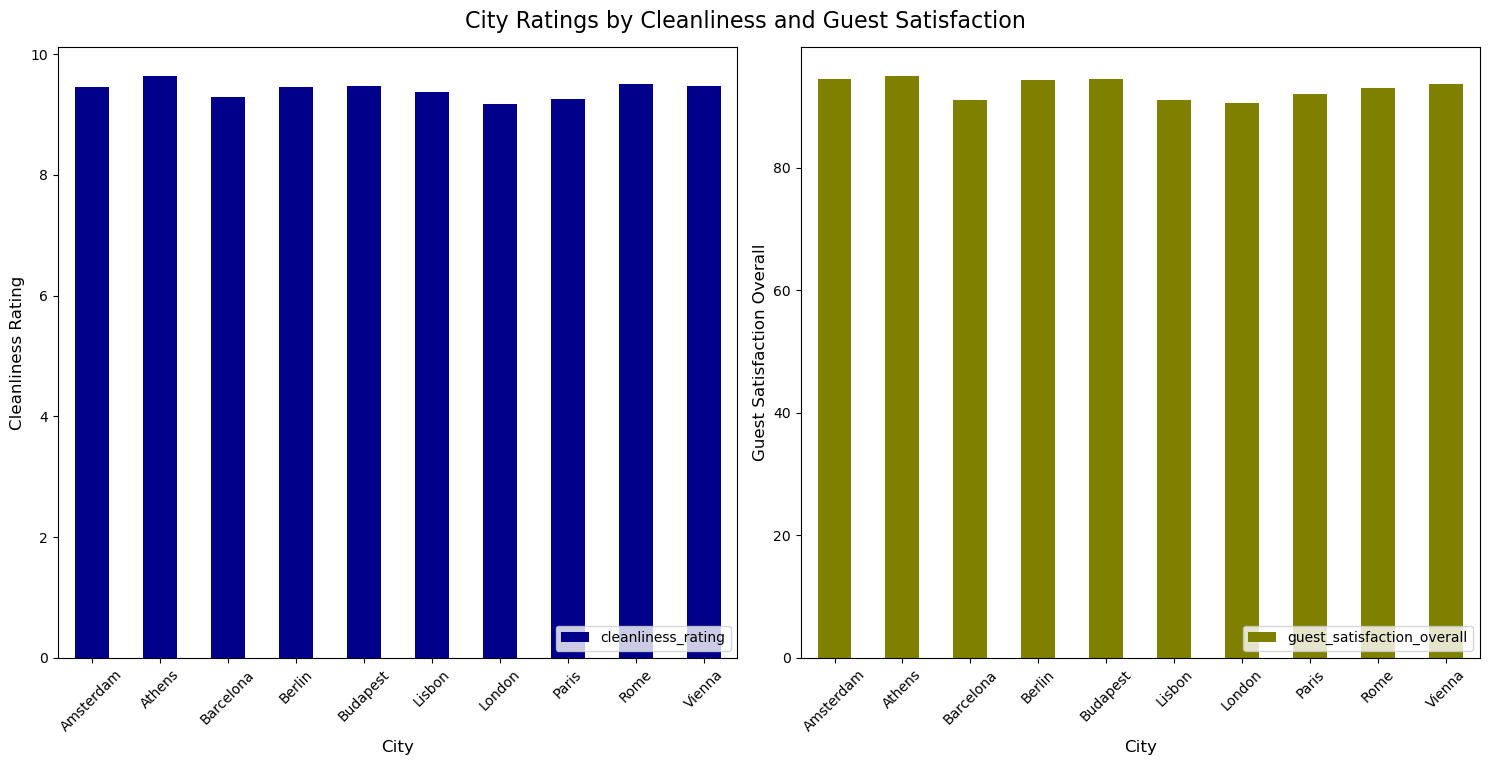

In [53]:
# Strip any leading/trailing spaces and convert to string (if necessary)
ratio_cleanliness_satisfaction['City'] = ratio_cleanliness_satisfaction['City'].str.strip()

# Sort the dataframe by cleanliness_rating in ascending order
ratio_cleanliness_satisfaction = ratio_cleanliness_satisfaction.sort_values(by='City', ascending=True)

# Plotting bar chart
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Plotting cleanliness rating
ratio_cleanliness_satisfaction.plot.bar(
    x='City', 
    y='cleanliness_rating', 
    color='darkblue', 
    ax=ax[0]
)

# Plotting guest satisfaction overall
ratio_cleanliness_satisfaction.plot.bar(
    x='City', 
    y='guest_satisfaction_overall', 
    color='olive', 
    ax=ax[1]
)

# Settings for the first subplot
ax[0].set_xlabel('City', fontsize=12)
ax[0].set_ylabel('Cleanliness Rating', fontsize=12)
ax[0].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[0].legend(loc='lower right')

# Settings for the second subplot
ax[1].set_xlabel('City', fontsize=12)
ax[1].set_ylabel('Guest Satisfaction Overall', fontsize=12)
ax[1].legend(loc='lower right')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

# Adding a common title
fig.suptitle('City Ratings by Cleanliness and Guest Satisfaction', fontsize=16, y=0.95)

# Optimizing layout
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjusting to ensure the title doesn't overlap with the plots
plt.show();

<Figure size 640x480 with 0 Axes>

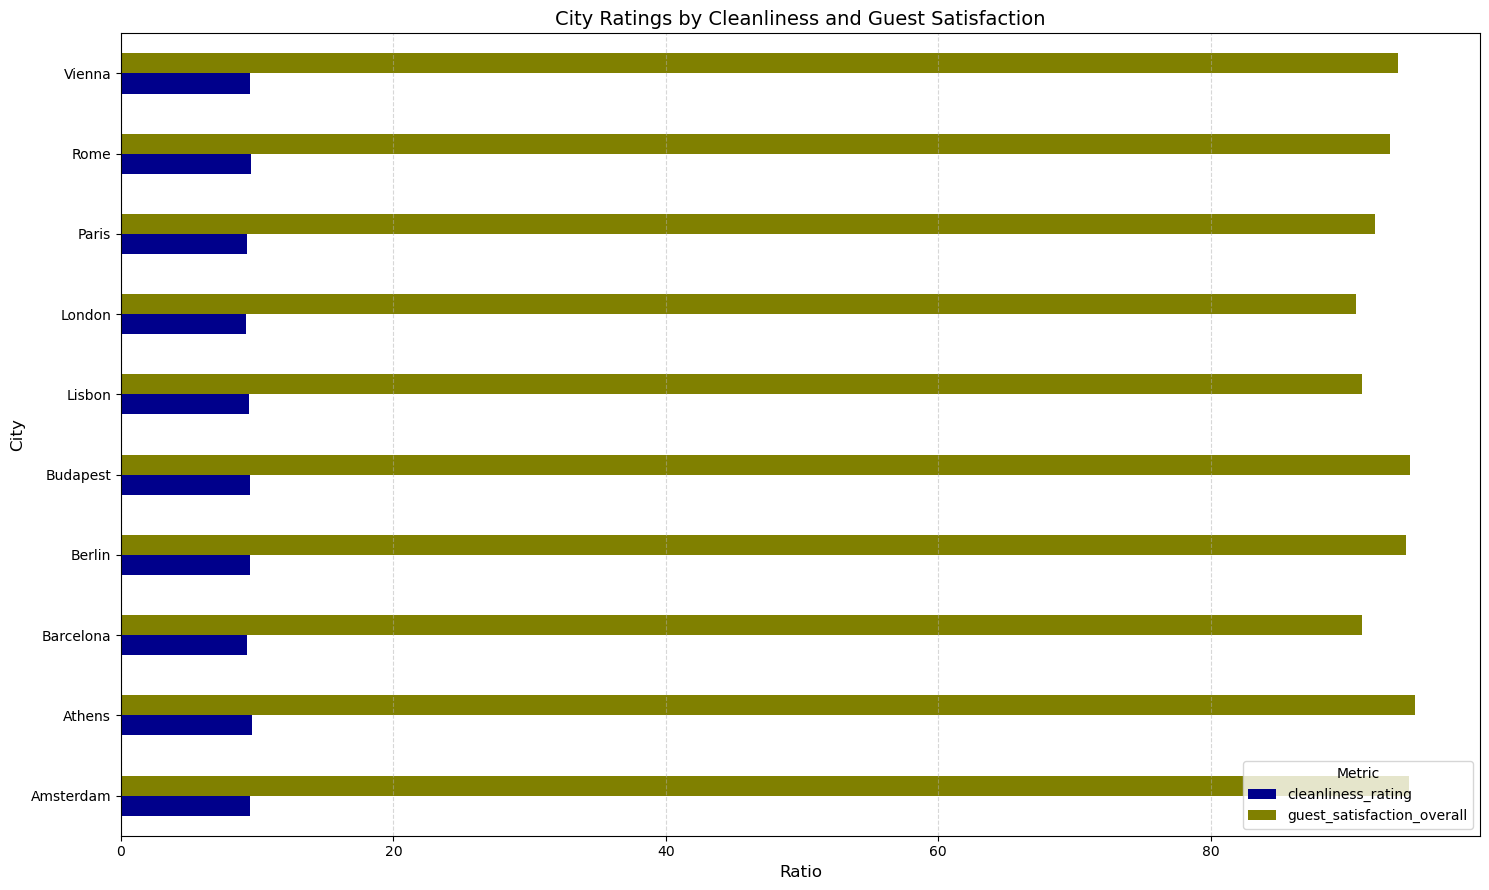

In [54]:
# Build a mixed chart of city ratings for cleanliness and guest satisfaction
plt.figure()

# Define colors for each metric
colors = ['darkblue', 'olive']

# Create the horizontal bar chart
ratio_cleanliness_satisfaction.plot.barh(
    x='City',
    color=colors,
    figsize=(15, 9)
)

# Set the title and labels
plt.title('City Ratings by Cleanliness and Guest Satisfaction', fontsize=14)
plt.xlabel('Ratio', fontsize=12)
plt.ylabel('City', fontsize=12)

# Add a legend with a title
plt.legend(title='Metric', loc='lower right')

# Optimize layout
plt.tight_layout()

# Add grid
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Display the plot
plt.show();

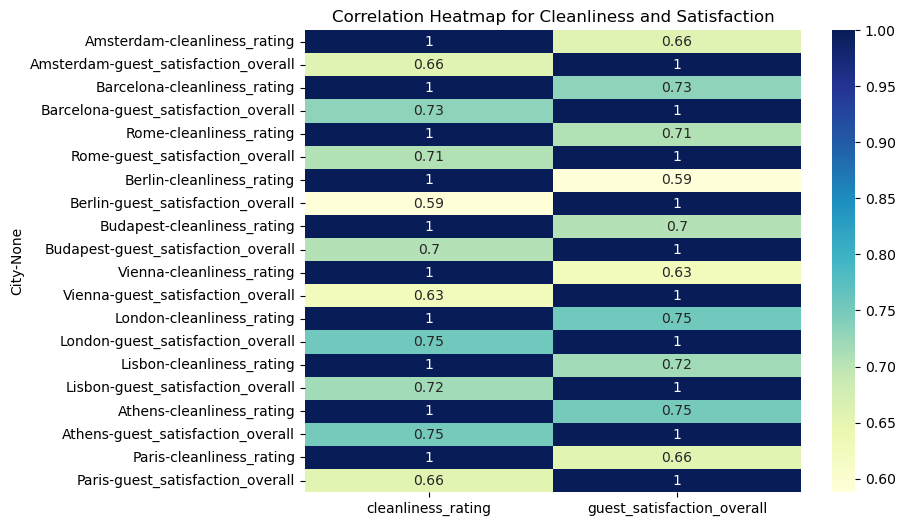

In [55]:
# Create a separate dataset for the most influential variables
cleanliness_satisfaction = (
    df.groupby('City')[['cleanliness_rating', 'guest_satisfaction_overall']]
)

# Calculate the correlation matrix
correlation_matrix = cleanliness_satisfaction.corr(method='pearson')

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))  
sns.heatmap(correlation_matrix, cmap='YlGnBu', annot=True)
plt.title('Correlation Heatmap for Cleanliness and Satisfaction') 
plt.show();

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Cleanliness ratings tend to have a strong impact on overall guest satisfaction, confirming previous findings about the correlation between cleanliness_rating and guest_satisfaction_overall.

Athens, Rome, and Budapest show the best cleanliness and guest satisfaction scores among other cities.
While London shows the worst results, which may signal some issues for landlords in that city.

In some cities, such as Amsterdam and Berlin, there is a smaller gap between the two metrics, which may indicate a balance of services.</div>

<div style="color: #8B4513; font-weight: bold; font-size: 16px;"> Let's supplement our analysis by testing for statistical significance between cleanliness_rating' and 'guest_satisfaction_overall between cities.</div>

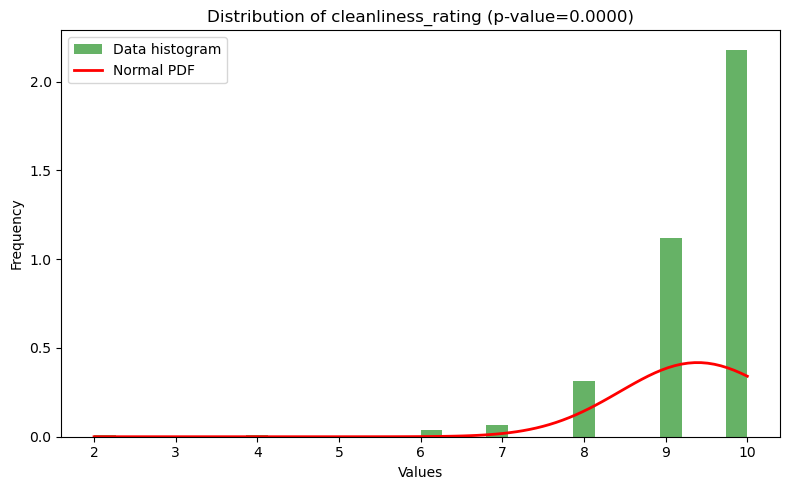

Column: cleanliness_rating
Test Statistic: 0.6413473060582502
p-value: 9.861198766436843e-133
Is Normal: No



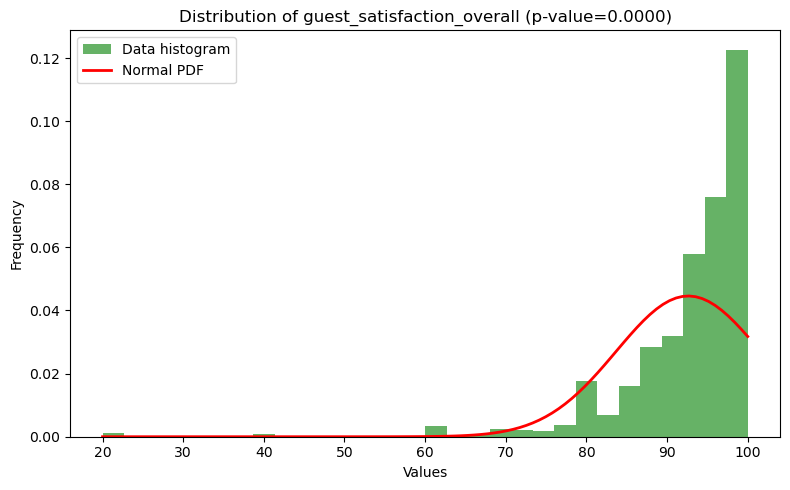

Column: guest_satisfaction_overall
Test Statistic: 0.7244150987784532
p-value: 4.638903081759669e-125
Is Normal: No



{'cleanliness_rating': (0.6413473060582502, 9.861198766436843e-133, False),
 'guest_satisfaction_overall': (0.7244150987784532,
  4.638903081759669e-125,
  False)}

In [58]:
# Check the sample for normality
colums_to_check = ['cleanliness_rating', 'guest_satisfaction_overall']
check_normality_for_columns(df, colums_to_check)

In [59]:
# Apply Permutation ANOVA test
for city in cities:
    
    # Filter the data for the current city
    city_data = df[df['City'] == city]
    
    # The function takes city data, 'guest_satisfaction_overall' as the dependent variable, and 'cleanliness_rating' as the factor
    p_value = permutation_anova(
        city_data, 
        dv='guest_satisfaction_overall', 
        between='cleanliness_rating', 
        n_permutations=10000
    )
    
    print(f"City: {city}, p-value: {p_value:.10f}")

City: Amsterdam, p-value: 0.0000000000
City: Barcelona, p-value: 0.0000000000
City: Rome, p-value: 0.0000000000
City: Berlin, p-value: 0.0000000000
City: Budapest, p-value: 0.0000000000
City: Vienna, p-value: 0.0000000000
City: London, p-value: 0.0000000000
City: Lisbon, p-value: 0.0000000000
City: Athens, p-value: 0.0000000000
City: Paris, p-value: 0.0000000000


<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Make a post-hoc testing to show which pairs of cities have statistically significant differences.

In [61]:
# Combining data for post hoc testing
combined_data = df[['City', 'guest_satisfaction_overall']]

# Post hoc testing
tukey_results = pairwise_tukeyhsd(
    endog=combined_data['guest_satisfaction_overall'],   # Dependent variable
    groups=combined_data['City'],                      # Groups(City)
    alpha=0.05                                         # Significance level
)

# Show the result
print(tukey_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
Amsterdam    Athens   0.4892 0.4949 -0.2321  1.2105  False
Amsterdam Barcelona  -3.4054    0.0 -4.2099 -2.6008   True
Amsterdam    Berlin  -0.1908 0.9993 -1.0189  0.6374  False
Amsterdam  Budapest   0.0709    1.0 -0.6817  0.8234  False
Amsterdam    Lisbon  -3.4205    0.0 -4.1333 -2.7078   True
Amsterdam    London  -3.8688    0.0 -4.5403 -3.1972   True
Amsterdam     Paris  -2.4769    0.0 -3.1764 -1.7774   True
Amsterdam      Rome  -1.3921    0.0 -2.0698 -0.7144   True
Amsterdam    Vienna  -0.7833 0.0423 -1.5532 -0.0134   True
   Athens Barcelona  -3.8945    0.0 -4.5434 -3.2456   True
   Athens    Berlin  -0.6799 0.0486 -1.3579  -0.002   True
   Athens  Budapest  -0.4183 0.4091 -1.0015  0.1648  False
   Athens    Lisbon  -3.9097    0.0 -4.4405 -3.3789   True
   Athens    London  -4.3579    0.0  -4.832 -3.8839   Tr

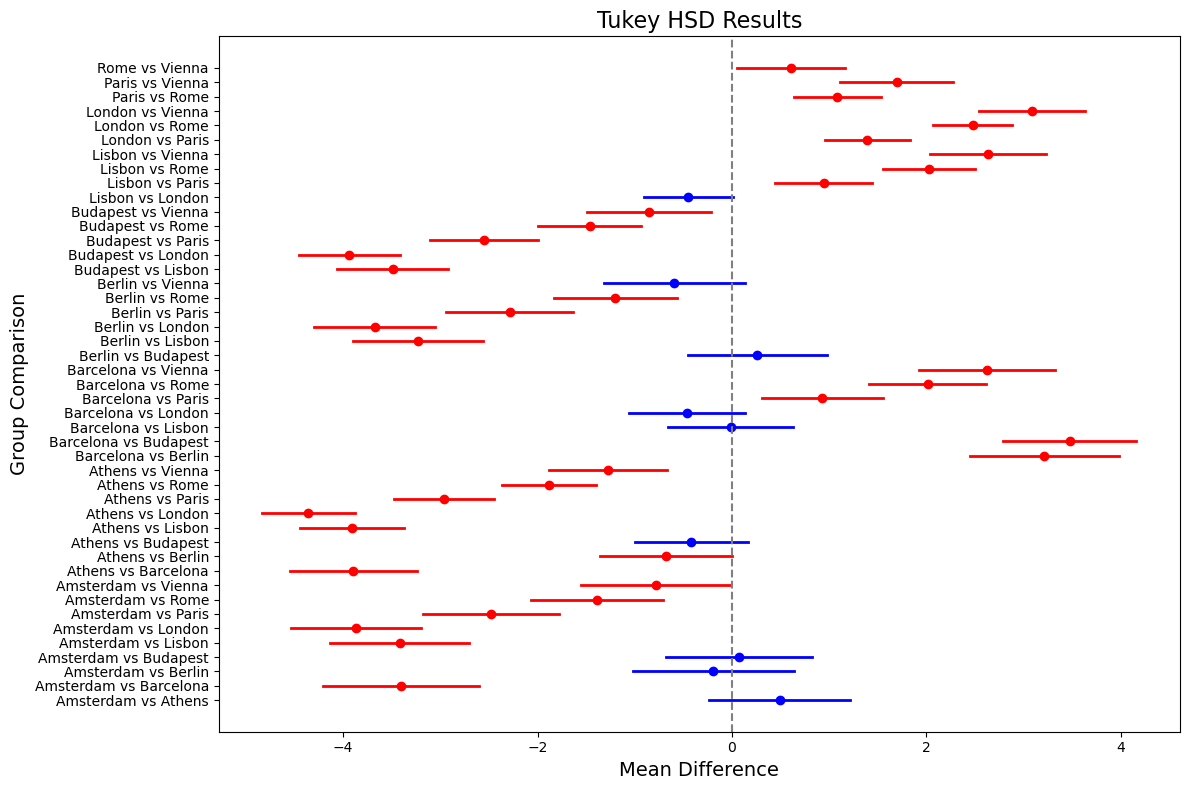

In [62]:
# Convert the results to a DataFrame
tukey_results_df = pd.DataFrame(
    data=tukey_results.summary().data[1:], 
    columns=tukey_results.summary().data[0]
)

# Visualization
plt.figure(figsize=(12, 8))
for i, row in tukey_results_df.iterrows():
    group1 = row['group1']
    group2 = row['group2']
    meandiff = row['meandiff']
    lower = row['lower']
    upper = row['upper']
    reject = row['reject']

    # Differences graph
    color = 'red' if reject else 'blue'
    plt.plot([lower, upper], [i, i], color=color, linewidth=2)  # Confidence interval line
    plt.plot(meandiff, i, 'o', color=color)  # Point for mean difference

# Adding signatures
plt.yticks(range(len(tukey_results_df)), tukey_results_df['group1'] + " vs " + tukey_results_df['group2'])
plt.axvline(0, color='gray', linestyle='--')  # Line for zero difference
plt.title('Tukey HSD Results', fontsize=16)
plt.xlabel('Mean Difference', fontsize=14)
plt.ylabel('Group Comparison', fontsize=14)
plt.tight_layout()
plt.show();

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Statistically Significant Differences Between Cities:</div>
<div style="color: #8B4513; font-size: 15px;">
The Tukey HSD test reveals that most city pairs show statistically significant differences in both cleanliness ratings and guest satisfaction scores. For example:
Athens and London demonstrate a substantial gap, with Athens outperforming London significantly in both metrics.
Rome and Berlin also display notable differences, highlighting Rome's stronger performance in cleanliness and guest satisfaction. </div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Cities with Similar Ratings:</div>
<div style="color: #8B4513; font-size: 15px;">
Some city pairs, such as Barcelona and Lisbon, do not show significant differences, indicating comparable levels of cleanliness and guest satisfaction in these locations.
These findings suggest that service quality in these cities is consistent, with no noticeable gaps in guest perception.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Top and Bottom Performers:</div>
<div style="color: #8B4513; font-size: 15px;">
Cities like Athens, Rome, and Budapest consistently appear among the top performers in cleanliness and guest satisfaction, as seen in the Tukey HSD results and visualization.
London consistently ranks lower, indicating a need for improvement in both metrics.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Visualization Insights:</div>
<div style="color: #8B4513; font-size: 15px;">
The forest plot highlights that most of the significant differences lean toward better-performing cities such as Athens, Rome, and Budapest, emphasizing their superior service quality compared to other cities.</div>

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Recommendations:</div>
<div style="color: #8B4513; font-size: 15px;">
    
1. Cities with Lower Ratings (e.g., London, Lisbon):
The post hoc analysis revealed statistically significant differences between cities with lower ratings (e.g., London) and those with higher ratings (e.g., Athens, Rome). This indicates a need for targeted improvement.
Focus Areas:
Conduct surveys to identify specific pain points for guests regarding cleanliness and overall satisfaction.
Implement stricter cleaning protocols, such as routine inspections and enhanced housekeeping services.
Offer training programs for staff to ensure a consistent standard of cleanliness.

2. Cities with Moderate Ratings (e.g., Amsterdam, Berlin):
For cities like Amsterdam and Berlin, where the gap between cleanliness and satisfaction ratings is smaller, maintaining consistency across listings is key.
Focus Areas:
Promote balanced improvements, such as adding additional guest amenities or personalized services, to enhance overall satisfaction further.
Utilize guest feedback systems to identify and address minor issues proactively.

3. Cities with High Ratings (e.g., Athens, Rome, Budapest):
Cities like Athens and Rome have demonstrated consistently high scores for both cleanliness and guest satisfaction.
Focus Areas:
Maintain current cleaning standards and service levels to preserve customer loyalty.
Use these cities as benchmarks to extract best practices, such as:
Highlighting unique features of high-rated properties in marketing materials.
Encouraging landlords to share successful cleaning and service practices within their network.    

4. Introduce Consistency Programs:
Establish city-wide standards for Airbnb hosts to ensure uniform guest experiences.
Enhance Communication:
Educate landlords on the direct impact of cleanliness on satisfaction to foster accountability and commitment.

5. Customized Marketing and Promotions:
Use the results of the post hoc analysis to create city-specific marketing campaigns:
For high-performing cities, emphasize their superior cleanliness and satisfaction ratings to attract premium clientele.
For cities with lower ratings, offer promotional discounts tied to visible service improvements.

6. Collaboration Across Cities:
Encourage collaboration among landlords in cities with differing performance levels:
Host workshops to share lessons learned from cities like Athens and Rome.
Provide incentives for landlords in lower-performing cities to adopt proven strategies.</div>

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
8. What is the impact of the number of bedrooms (bedrooms) and capacity (person_capacity) on the price (realSum)? </div>
<div style="color: #8B4513; font-size: 15px;">
Use regression analysis to investigate this issue.</div>

In [66]:
def linear_regression(col1, col2):
    """
    Perform linear regression for given dependent and independent variables.

    Parameters:
    col1 (str): Column name for independent variable(s) (X).
    col2 (str): Column name for dependent variable (y).

    Returns:
    tuple: Intercept and coefficients of the regression model.
    """
    # Dependent variable
    y = df[col2]
    # Independent variable(s), reshaped if needed
    X = df[[col1]] if isinstance(col1, str) else df[col1]

    # Create and train the model
    model = LinearRegression()
    model.fit(X, y)

    # Regression coefficients
    print(f'Intercept: {model.intercept_}')
    print(f'Coefficients: {model.coef_}')

    return model.intercept_, model.coef_

In [67]:
# Apply linear_regression function
intercept, coef = linear_regression(['bedrooms', 'person_capacity'], 'realSum')

Intercept: 92.8808577057932
Coefficients: [82.17713398 29.0275162 ]


<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
According to the analysis, we see that the "bedroom" indicator has a greater impact on the price than the human capacity.
Let's look at these dependencies graphically.</div>

In [69]:
def visualization_lmplot(col1, col2):
    """
    Visualize a scatterplot with regression lines for given features.

    Parameters:
    col1 (list): List of independent variable(s) to plot (e.g., ['bedrooms', 'person_capacity']).
    col2 (str): Dependent variable to plot against (e.g., 'realSum').

    Returns:
    None
    """
    # Prepare data for lmplot
    df_melted = df.melt(
        id_vars=col2,
        value_vars=col1,
        var_name='Feature',
        value_name='Value'
    )

    # lmplot with split regression lines
    sns.lmplot(
        x='Value',
        y=col2,
        hue='Feature',
        data=df_melted,
        aspect=1.5,
        scatter_kws={'alpha': 0.6},
        line_kws={'alpha': 0.8}
    )
    plt.title(f'Scatterplot and Regression for {col1}')
    plt.xlabel('Feature Value')
    plt.ylabel(col2)
    plt.show();

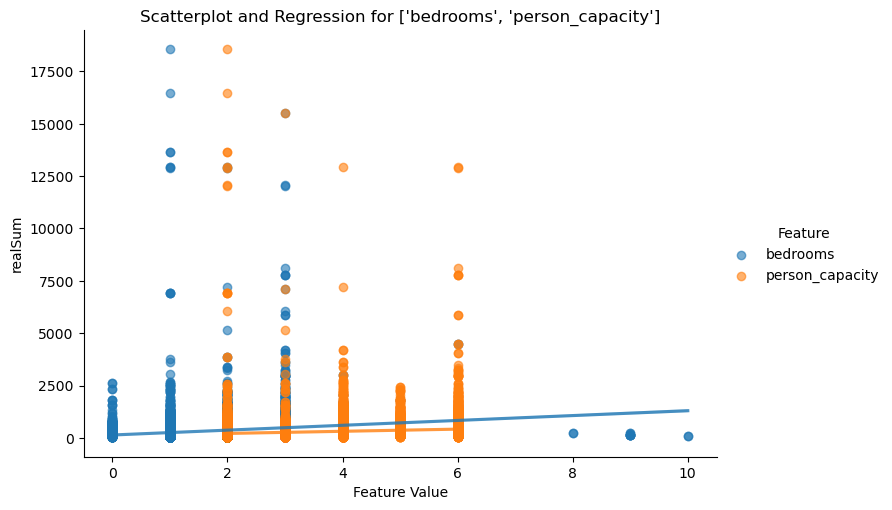

In [70]:
#Apply the visualization function
visualization_lmplot(['bedrooms', 'person_capacity'], 'realSum')

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
According to the results of the regression analysis:</div>
<div style="color: #8B4513; font-size: 15px;">
Intercept - Value: 92.88
If the number of bedrooms (bedrooms) and capacity (person_capacity) are both zero (theoretically), the predicted rental price (realSum) would be 92.88 units.

Coefficients:
82.18 for bedrooms
Each additional bedroom increases the predicted rental price by 82.18 units.
29.03 for person_capacity
Each additional increase in capacity by one person adds 29.03 units to the predicted rental price.

These coefficients indicate how each variable impacts the rental price (realSum), assuming all other variables remain constant:
Each additional bedroom has a larger influence on the rental price compared to an increase in capacity by one person.
From the small slope of the regression lines, it is evident that bedrooms has a greater impact on realSum than person_capacity.

The high dispersion of data points around the regression lines suggests that rental prices vary significantly even with the same number of bedrooms or capacity. This may indicate that customers value the number of rooms more than the overall capacity.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
This implies that other factors (such as location, cleanliness rating) also significantly influence rental prices.</div>

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
9. How  geographical factors (dist, metro_dist, lat, lng, attr_index_norm, rest_index_norm) affect the rent price? </div>

In [73]:
# Apply linear_regression function
intercept, coef = linear_regression(['dist', 'metro_dist', 'lat', 'lng', 'attr_index_norm', 'rest_index_norm'], 'realSum') 

Intercept: -148.53186042331083
Coefficients: [-10.31877767   0.53276894   8.91700305  -4.04715602   6.16224677
   0.04663599]


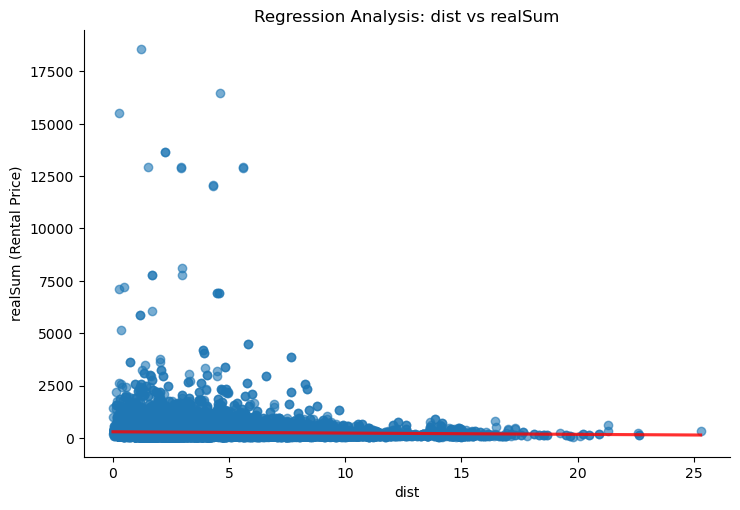

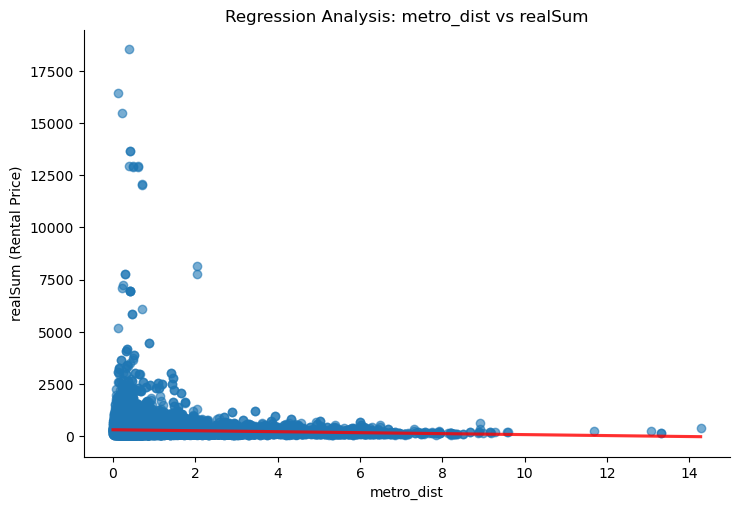

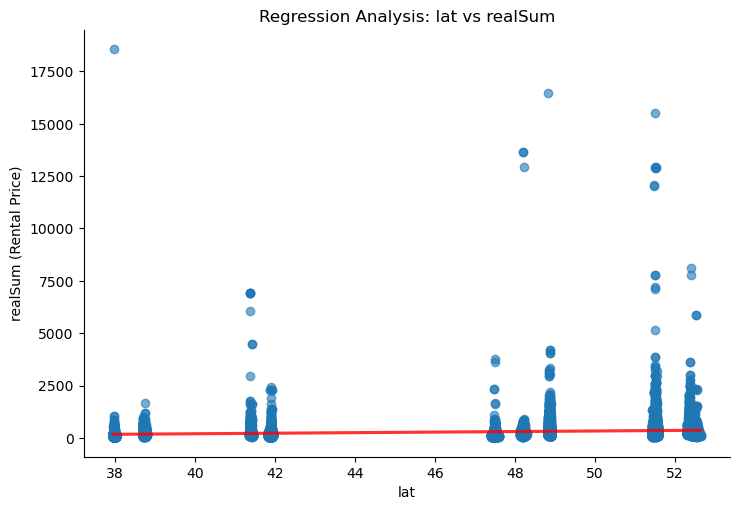

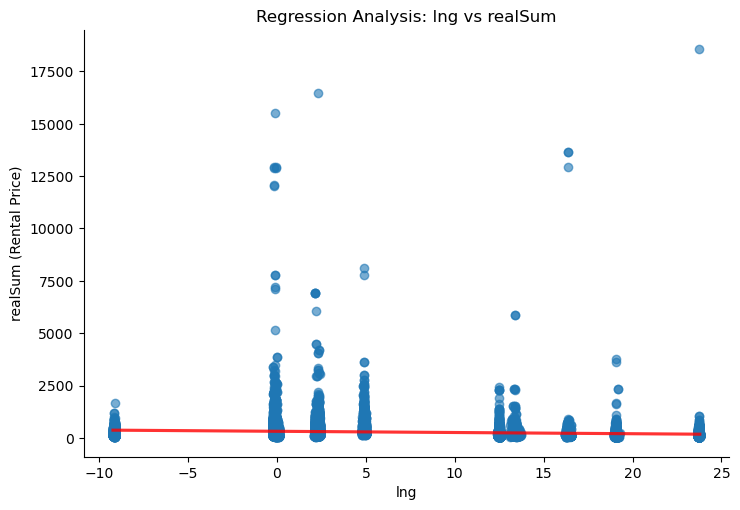

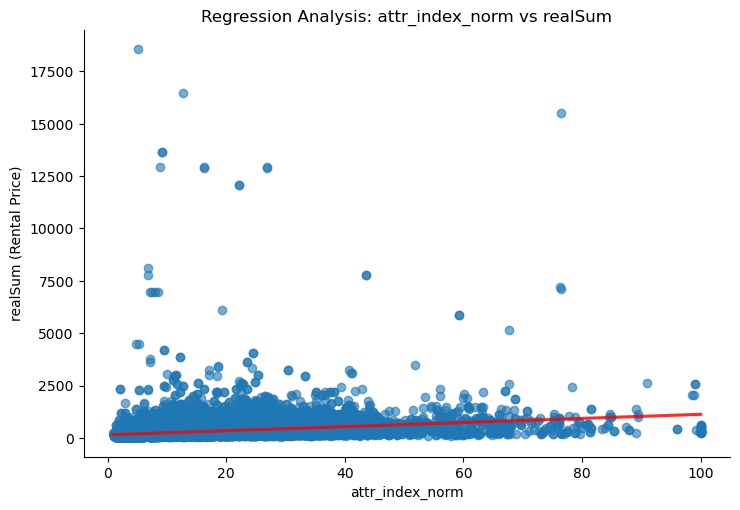

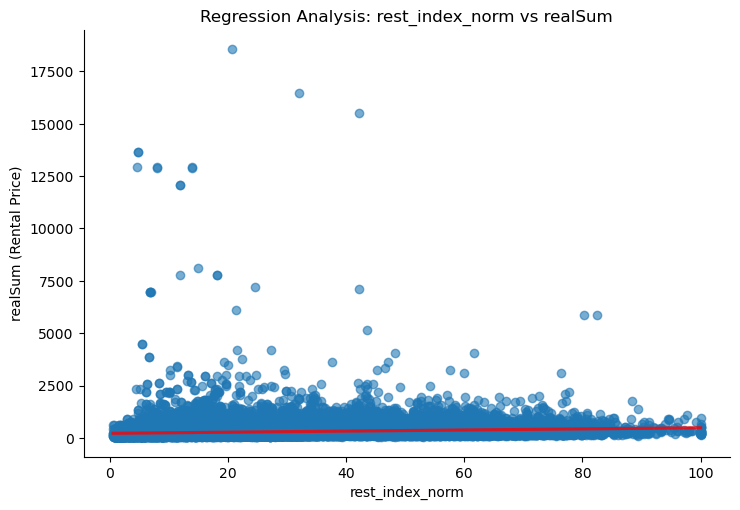

In [74]:
check_regretion_col = ['dist', 'metro_dist', 'lat', 'lng', 'attr_index_norm', 'rest_index_norm']

# Loop through each column and create separate regression plots
for col in check_regretion_col:
    sns.lmplot(
        x=col, 
        y='realSum', 
        data=df, 
        aspect=1.5, 
        scatter_kws={'alpha': 0.6}, 
        line_kws={'alpha': 0.8, 'color': 'red'}
    )
    
    # Plotting regression analysis
    plt.title(f'Regression Analysis: {col} vs realSum')
    plt.xlabel(f'{col}')
    plt.ylabel('realSum (Rental Price)')
    plt.show();

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Since linear regression did not show any results, let's try using another method to test the influence of geographic location indicators on rental prices. We will use cluster analysis.</div>

In [76]:
# Function for calculating and visualizing using the "elbow" method
def elbow_method(data, features, max_clusters=10):
    """
    Determines the optimal number of clusters using the Elbow Method.
    
    Parameters:
    data (DataFrame): The dataset.
    features (list): List of feature names for clustering.
    max_clusters (int): Maximum number of clusters to consider (default is 10).
    
    Returns:
    None
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[features])
    
    # List for storing inertia values
    inertia = []
    
    # Calculation of inertia for different numbers of clusters
    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(scaled_data)
        inertia.append(kmeans.inertia_)
    
    # Visualization of the "elbow" method
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title(f'Elbow Method for Optimal Clusters of {features}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.xticks(range(1, max_clusters + 1))
    plt.grid()
    plt.show();

In [77]:
# Create function for division into clusters 
def cluster_analysis(df, features, n_clusters, cluster_col_name='Cluster'):
    """
    Perform cluster analysis and add results to a specified column in the DataFrame.

    Parameters:
    ----------
    df : DataFrame
        The dataset.
    features : list
        List of feature names for clustering.
    n_clusters : int
        Number of clusters.
    cluster_col_name : str, optional
        The name of the column to store the cluster labels (default is 'Cluster').

    Returns:
    -------
    clusters : array
        Cluster labels for each observation.
    """

    # Standardize the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[features])
    
    # Perform clustering using k-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    
    # Add the clustered labels to the specified column in the DataFrame
    df[cluster_col_name] = clusters
    
    return clusters

In [78]:
# Vizualisation clusters
def plot_clusters(data, x_col, y_col, cluster_col, size_col, title, x_label, y_label, size_range=(10, 1000), palette='flare'):
    """
    Plots a scatterplot of clusters with adjustable parameters.

    Parameters:
    ----------
    data : pandas.DataFrame
        The dataframe containing the data to be plotted.
    x_col : str
        The column name for the x-axis.
    y_col : str
        The column name for the y-axis.
    cluster_col : str
        The column name representing the cluster labels.
    size_col : str
        The column name for determining the size of the scatter points.
    title : str
        The title of the plot.
    x_label : str
        The label for the x-axis.
    y_label : str
        The label for the y-axis.
    size_range : tuple, optional
        A tuple specifying the minimum and maximum sizes for the scatter points (default is (20, 200)).
    palette : str, optional
        The color palette for the clusters (default is 'viridis').

    Returns:
    -------
    None
        Displays the scatterplot.
    """
    # Set the plot size
    plt.figure(figsize=(10, 6))
    
    # Create the scatterplot
    sns.scatterplot(
        data=data,
        x=x_col,
        y=y_col,
        hue=cluster_col,
        size=size_col,
        sizes=size_range,
        palette=palette,
        alpha=0.3
    )
    
    # Set plot title and axis labels
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Add a legend for clusters
    plt.legend()
    
    # Display the plot
    plt.show();

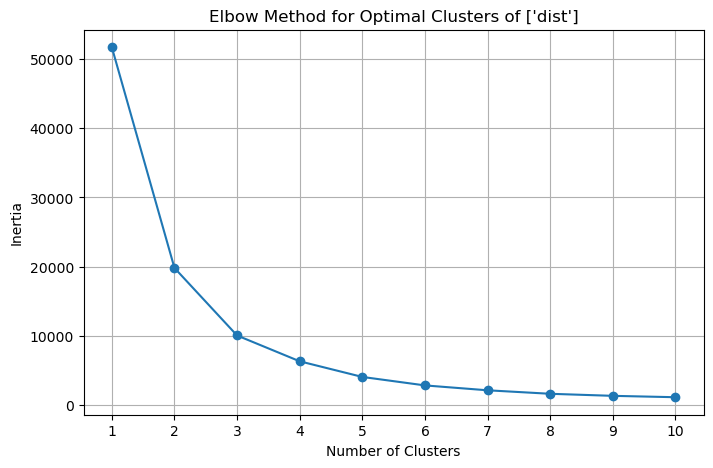

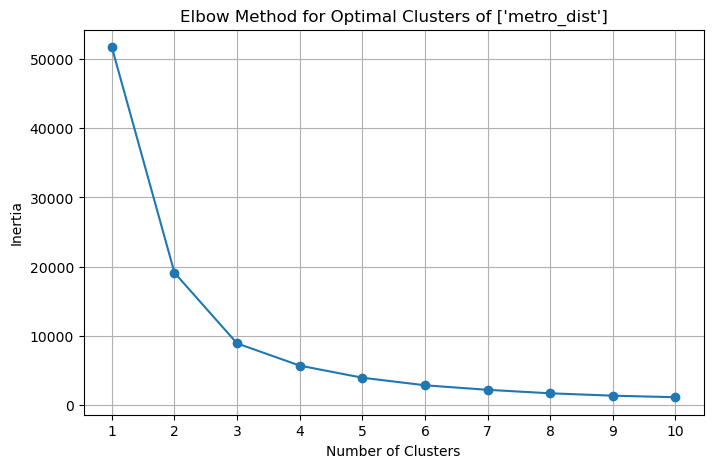

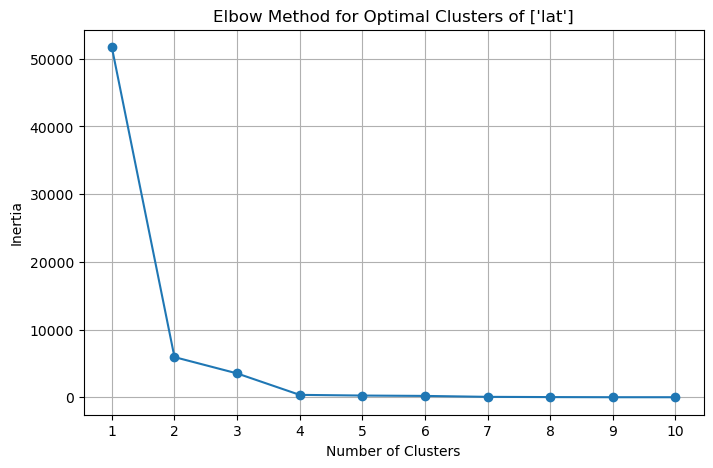

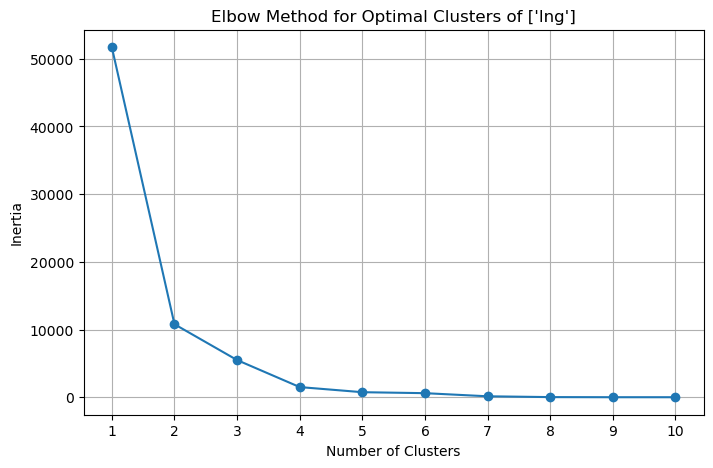

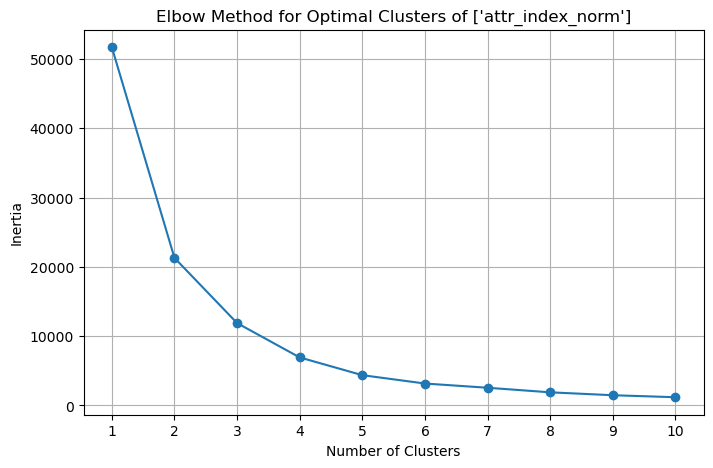

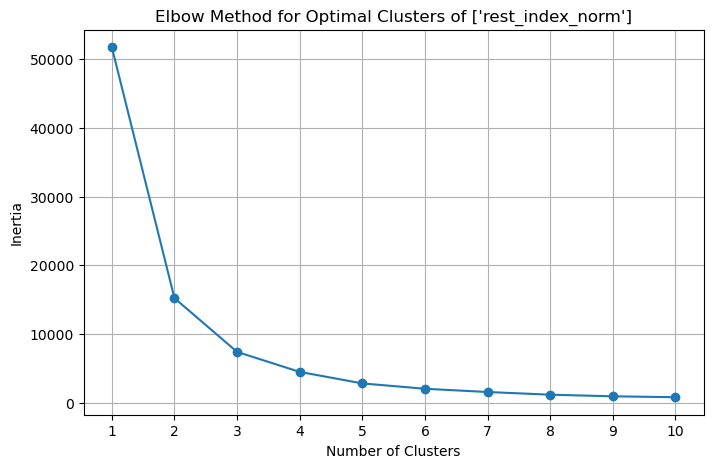

In [79]:
# Calling a function to select the optimal number of clusters
for col in check_regretion_col:
    elbow_method(df, features=[col])

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
According to the elbow method, I will divide the data into 3 clusters to provide more detailed insights into geographical indicators. Additionally, I will group some columns together: dist & metro_dist, lng & lat, and attr_index_norm & rest_index_norm, to explore how price might depend on geographic locations.</div>

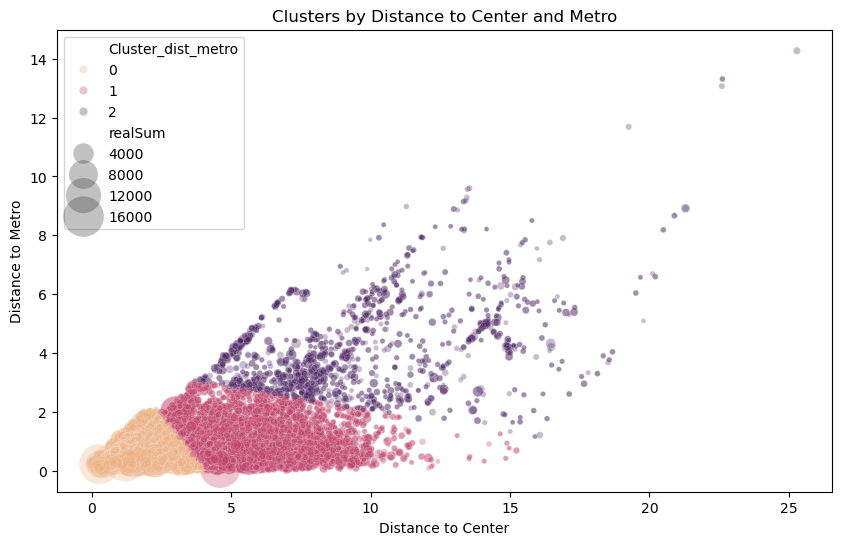

In [81]:
# Apply cluster analysis function
cluster_analysis(
    df, 
    features=['dist', 'metro_dist'], 
    n_clusters=3, 
    cluster_col_name='Cluster_dist_metro'
)
plot_clusters(
    data=df,
    x_col='dist',
    y_col='metro_dist',
    cluster_col='Cluster_dist_metro',
    size_col='realSum',
    title='Clusters by Distance to Center and Metro',
    x_label='Distance to Center',
    y_label='Distance to Metro'
)

In [82]:
# Average values ​​of variables for each cluster
cluster_summary_dist = ( 
    df.groupby('Cluster_dist_metro')[['realSum', 'dist', 'metro_dist']]
    .mean()
)

display(cluster_summary_dist)

,realSum,dist,metro_dist
Cluster_dist_metro,,,
0,284.131,1.868,0.435
1,279.945,5.289,0.804
2,202.448,9.429,4.102


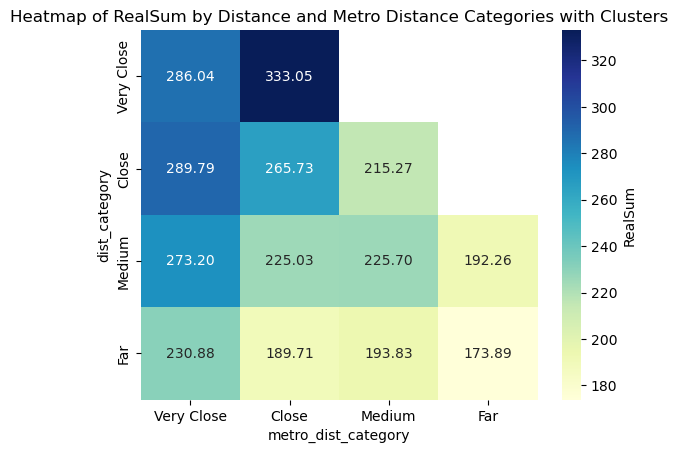

In [83]:
# Creating a pivot table to calculate the mean of 'realSum' based on 'dist_category' and 'metro_dist_category'
pivot_dist = pd.pivot_table(
    df,
    index='dist_category',
    columns='metro_dist_category',
    values='realSum',
    aggfunc='mean'
)

# Plotting a heatmap with the pivot table data
sns.heatmap(
    pivot_dist,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'RealSum'}
)

# Adding a title to the heatmap
plt.title("Heatmap of RealSum by Distance and Metro Distance Categories with Clusters")

plt.show();

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Conclusion:</div>
<div style="color: #8B4513; font-size: 15px;">
The analysis shows a significant clustering of points in Cluster 0, where the distance to the metro is less than 2 units and the distance to the city center is up to 5 units. Correspondingly, the average rental price in this cluster is the highest.

An interesting observation is that proximity to the metro appears to be more influential on price formation than proximity to the city center. This could be because city centers are not always convenient or dense enough to meet tourists’ needs, and renters prioritize metro access for seamless travel to desired destinations.

In Cluster 1, proximity to the metro remains important, with distances still within 2 units. However, the distance to the city center increases, ranging up to 10 units. Notably, there is a concentration of points around 5 units, indicating higher prices in this range.

Cluster 2 exhibits significantly lower average rental prices compared to the other clusters (202.5 USD). Here, the average distance to the metro increases to approximately 4 units, while the distance to the city center ranges from 9 to 10 units.

Finally, the heatmap supports the hypothesis that renters prioritize metro accessibility over proximity to the city center when set prices, confirming our initial assumption.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Recommendations for Hosts:
Emphasize Metro Accessibility:</div>
<div style="color: #8B4513;font-size: 15px;">
Hosts aiming to maximize rental prices should highlight proximity to metro stations in their property descriptions. For example, mention that "the property is within a 5-minute walk to the metro."
If the property is further from the metro, consider providing detailed information on nearby transport routes or offering a shuttle service to the nearest station.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Optimize Pricing for Suburban Properties:</div>
<div style="color: #8B4513;font-size: 15px;">
For properties located in Cluster 2 (greater distance from the metro and city center), focus on other strengths such as quiet surroundings, scenic views, or accessibility to unique local attractions.
Providing additional amenities like rental bikes or metro passes can also attract more renters and justify slightly higher prices.</div>


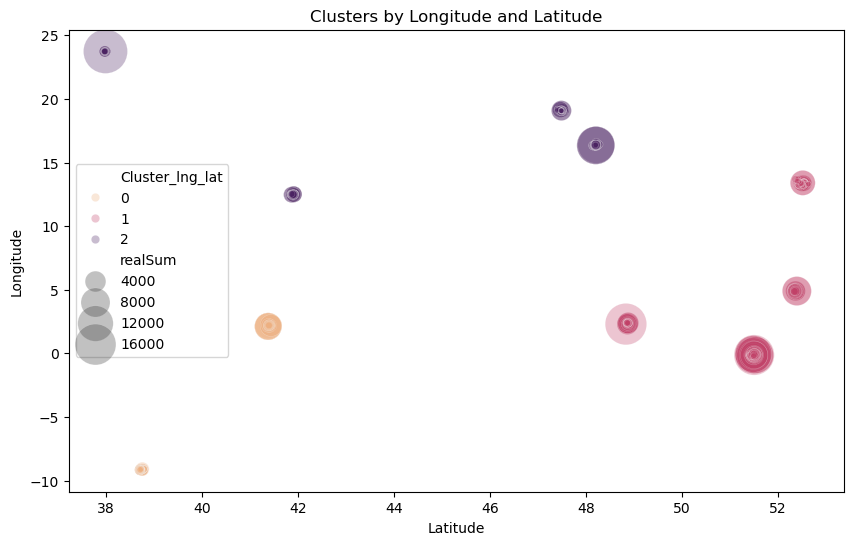

In [85]:
# Apply cluster analysis function
cluster_analysis(
    df,
    features=['lng', 'lat'], 
    n_clusters=3, 
    cluster_col_name='Cluster_lng_lat'
)
plot_clusters(
    data=df,
    x_col='lat',
    y_col='lng',
    cluster_col='Cluster_lng_lat',
    size_col='realSum',
    title='Clusters by Longitude and Latitude',
    x_label='Latitude',
    y_label='Longitude'
)

In [86]:
# Average values ​​of variables for each cluster
cluster_summary_latitudes = (
    df.groupby('Cluster_lng_lat')[['realSum', 'lng', 'lat']]
    .mean()
)
display(cluster_summary_latitudes)

,realSum,lng,lat
Cluster_lng_lat,,,
0,256.516,-5.415,39.602
1,378.773,2.729,50.875
2,192.980,17.038,43.001


<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
During clustering, we see:</div>
<div style="color: #8B4513; font-size: 15px;">
    
- In cluster 0 - average price is 256.52 USD, average coordinates: Longitude = -5.415, Latitude = 39.602.
This cluster likely represents properties located in the western or southwestern parts of Europe (e.g., Lisbon or Barcelona).
The price here is lower than in Cluster 1 but higher than in Cluster 2, possibly due to a combination of moderate tourist demand and accessibility to services.
- Cluster 1 - average price is 378.77 USD, average coordinates: Longitude = 2.729, Latitude = 50.875.
This cluster has the highest average price among all clusters.
The latitude and longitude indicate properties located in central or western Europe (e.g., Paris or Amsterdam).
High prices are likely driven by the presence of major urban centers with significant demand for rentals and also it could be the high level of the economy in these cities, the higher the standard of living and, accordingly, the higher the pricing policy.
- In cluster 2 - the lowest average price among all clusters. Average Price: 192.98 USD, average coordinates: Longitude = 17.038, Latitude = 43.001.
The coordinates suggest properties located in eastern or southeastern Europe(e.g., Budapest). Lower prices may be attributed to less developed tourist infrastructure or lower demand for rentals in these regions.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Recommendations:</div>
<div style="color: #8B4513; font-size: 15px;">
    
For Hosts in Cluster 2:
To attract tourists and increase revenue, emphasize the natural or cultural advantages of these regions.
Offer additional amenities or services (e.g., transportation or guided tours) to increase the perceived value of the rental.

For Hosts in Clusters 0 and 1:
Highlight the benefits of central or western locations, such as proximity to urban centers, convenient transport options, or cultural richness, to justify higher prices.</div>

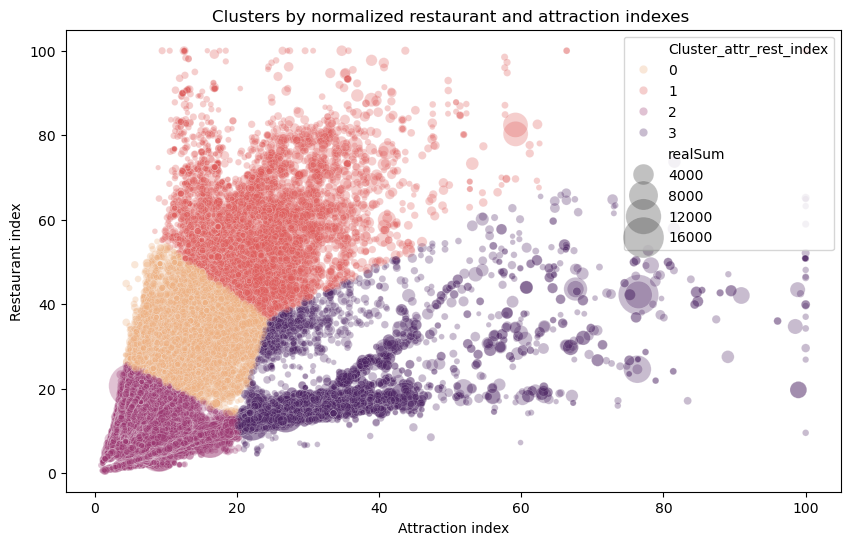

In [88]:
# Apply cluster analysis function
cluster_analysis(
    df,
    features=['attr_index_norm', 'rest_index_norm'], 
    n_clusters=4, 
    cluster_col_name='Cluster_attr_rest_index'
)
plot_clusters(
    data=df,
    x_col='attr_index_norm',
    y_col='rest_index_norm',
    cluster_col='Cluster_attr_rest_index',
    size_col='realSum',
    title='Clusters by normalized restaurant and attraction indexes ',
    x_label='Attraction index',
    y_label='Restaurant index'
)

In [89]:
# Average values ​​of variables for each cluster
cluster_summary_attractions = (
    df.groupby('Cluster_attr_rest_index')[['realSum', 'attr_index_norm', 'rest_index_norm']]
    .mean()
)
display(cluster_summary_attractions)

,realSum,attr_index_norm,rest_index_norm
Cluster_attr_rest_index,,,
0,276.329,13.194,31.936
1,382.518,22.544,57.430
2,224.280,7.748,10.002
3,446.149,31.795,19.747


<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
To analyze the impact of accessibility to attractions and restaurants on rental prices, the data was divided into 4 clusters. Since lower index values indicate closer proximity to these amenities, the following observations were made:</div>
<div style="color: #8B4513; font-size: 15px;">

- Cluster 3:
Average rental price: The highest among all clusters.
Distance to attractions: Farther away (average index value = 32 out of 100), with properties located at the farthest distances.
Distance to restaurants: Mostly medium (index values between 20-40).
Interpretation: Despite high prices, these properties are not located near key tourist attractions or restaurants. This suggests that other factors, such as the uniqueness of the location, tranquility, authenticity, or the quality of local dining options, are driving the higher prices.
- Cluster 1:
Average rental price: The second highest, after Cluster 3.
Distance to attractions: Closer than Cluster 3 (average index = 22.5).
Distance to restaurants: The farthest among all clusters (average index = 57.4).
Interpretation: Proximity to attractions seems to have a strong influence on prices in this cluster, while the greater distance to restaurants suggests less emphasis on gastronomic tourism.
- Cluster 0:
Average rental price: Lower than Clusters 3 and 1.
Distance to attractions: The closest among all clusters (low attraction index).
Distance to restaurants: Medium (moderate restaurant index).
Interpretation: This cluster appears balanced, offering decent accessibility to both attractions and restaurants. It appeals to tourists seeking convenience and affordability.
- Cluster 2:
Average rental price: The lowest among all clusters.
Distance to attractions and restaurants: The closest (low index values for both).
Interpretation: Despite the advantageous location, the lower prices may be due to other factors such as difficulty accessing these properties (e.g., narrow streets in historical centers), older property conditions, or noisier surroundings due to high tourist activity.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Key Takeaways:
    
Location is not always the primary determinant of rental prices. For example, properties in Cluster 3 with high prices are situated farther from attractions and restaurants, indicating the importance of other factors such as uniqueness or property quality.
Conversely, properties in Cluster 2, despite their excellent proximity to attractions and restaurants, have the lowest prices. This may be due to accessibility challenges or property conditions.

Business Recommendations: </div>
<div style="color: #8B4513; font-size: 15px;">

For Hosts in Cluster 3:
Highlight the unique benefits of the location, such as tranquility, authenticity, or high-quality dining options. These factors are likely driving the high rental prices.
Market properties as ideal for tourists seeking a quieter or more authentic experience away from crowded tourist hotspots.

For Hosts in Cluster 2:
Improve property accessibility (e.g., providing clear directions or transportation services).
Focus on upgrading the property’s quality or offering extra amenities (e.g., soundproofing or guided tours) to make it more attractive to renters and justify higher prices.</div>


<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
What Impacts Rental Price?</div>
<div style="color: #8B4513; font-size: 15px;">
Proximity to the metro is the most critical geographical factor, as properties close to metro stations consistently command higher prices, even if they are farther from the city center (Distance to Metro/City Center group).

Regional location (latitude/longitude) reflects broader economic and cultural factors:
Central and Western Europe drives higher prices due to urban hubs with high demand.
Eastern and Southeastern Europe, despite rich culture, shows lower prices due to reduced demand and infrastructure.

Proximity to attractions and restaurants reveals nuanced dynamics:
Properties farther from attractions and moderately close to restaurants (Cluster 3) can still achieve high prices, emphasizing non-geographical factors such as exclusivity, tranquility, and quality of dining.
Excellent proximity to both attractions and restaurants does not guarantee high prices, as seen in Cluster 2, where other limitations (e.g., accessibility, property quality) likely reduce demand.

Ultimately, rental prices are influenced by a combination of factors. While geographical attributes like metro accessibility and regional location play a strong role, non-geographical factors such as property quality, tranquility, and exclusivity can significantly impact pricing, even in less accessible areas.</div>

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">10. How do geographical factors (latitude, longitude, and distance) affect guest satisfaction (guest_satisfaction_overall)?

In [93]:
# Create pivot tables for guest satisfaction by categories
lat_pivot = pd.pivot_table(
    df,
    index='lat_category',
    values='guest_satisfaction_overall',
    aggfunc='mean'
)
lng_pivot = pd.pivot_table(
    df,
    index='lng_category',
    values='guest_satisfaction_overall',
    aggfunc='mean'
)
metro_dist_pivot = pd.pivot_table(
    df,
    index='metro_dist_category',
    values='guest_satisfaction_overall',
    aggfunc='mean'
)

# Add a column to indicate the source of each pivot table
lat_pivot['Category'] = 'Latitude'
lng_pivot['Category'] = 'Longitude'
metro_dist_pivot['Category'] = 'Metro Distance'

# Concatenate pivot tables
combined_pivot = pd.concat([lat_pivot, lng_pivot, metro_dist_pivot])

# Apply a gradient style and display each pivot table by category
for category, group in combined_pivot.groupby('Category'):
    print(f"Category: {category}")
    display(group.style.background_gradient(cmap='YlGnBu', subset=['guest_satisfaction_overall']))

Category: Latitude


,guest_satisfaction_overall,Category
South,92.584679,Latitude
Mid-South,93.122300,Latitude
Mid-North,93.177230,Latitude
North,91.826063,Latitude


Category: Longitude


,guest_satisfaction_overall,Category
West,91.093875,Longitude
Mid-West,91.510188,Longitude
Mid-East,93.381548,Longitude
East,94.522003,Longitude


Category: Metro Distance


,guest_satisfaction_overall,Category
Very Close,92.470243,Metro Distance
Close,93.497613,Metro Distance
Medium,92.951913,Metro Distance
Far,92.430769,Metro Distance


<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
From these results, the conclusion follows that the most satisfied customers are in the Mid-North latitude region, East - longitude and if the accommodation is close to the metro.</div>

Average guest satisfaction by latitude clusters:


,guest_satisfaction_overall,realSum
Cluster_lng_lat,,
0,91.099,256.516
1,91.893,378.773
2,93.944,192.980


Average guest satisfaction by distance to metro and city center clusters:


,guest_satisfaction_overall,realSum
Cluster_dist_metro,,
0,92.684,284.131
1,92.458,279.945
2,93.056,202.448


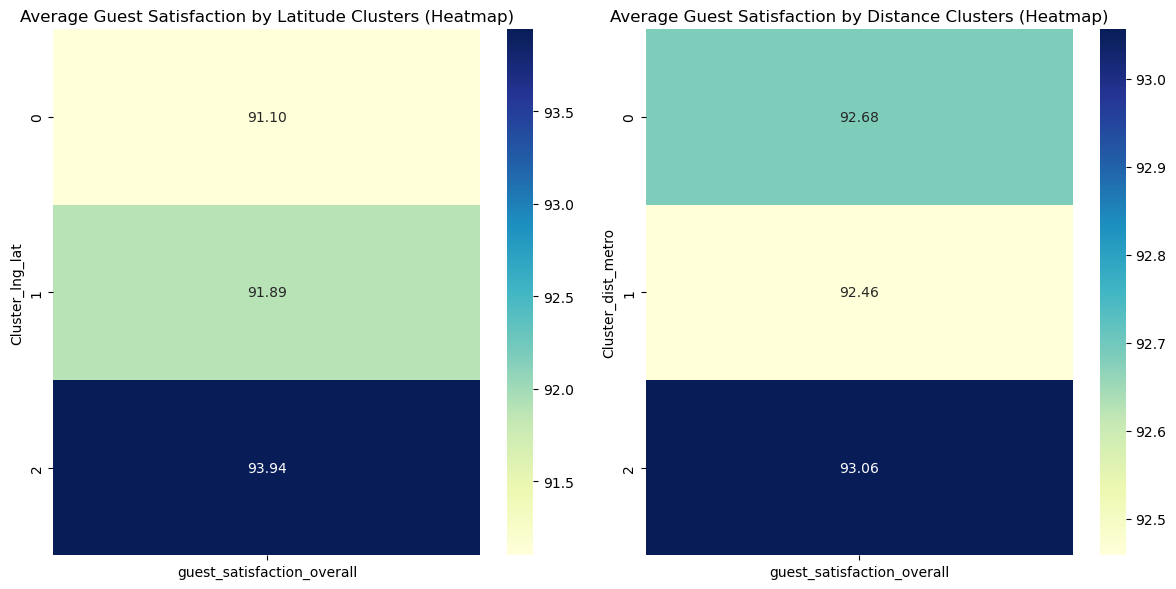

In [95]:
# Group data by clusters and calculate average satisfaction and rent
satisfaction_by_cluster_lng_lat = (
    df.groupby('Cluster_lng_lat')[['guest_satisfaction_overall', 'realSum']]
    .mean()
)
satisfaction_by_cluster_dist_metro = (
    df.groupby('Cluster_dist_metro')[['guest_satisfaction_overall', 'realSum']]
    .mean()
)

# Display average guest satisfaction by clusters
print('Average guest satisfaction by latitude clusters:')
display(satisfaction_by_cluster_lng_lat)
print('Average guest satisfaction by distance to metro and city center clusters:')
display(satisfaction_by_cluster_dist_metro)

# Plot heatmaps for average satisfaction by clusters
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(
    satisfaction_by_cluster_lng_lat[['guest_satisfaction_overall']],
    annot=True,
    cmap='YlGnBu',
    fmt='.2f',
    ax=axes[0]
)
sns.heatmap(
    satisfaction_by_cluster_dist_metro[['guest_satisfaction_overall']],
    annot=True,
    cmap='YlGnBu',
    fmt='.2f',
    ax=axes[1]
)

axes[0].set_title('Average Guest Satisfaction by Latitude Clusters (Heatmap)')
axes[1].set_title('Average Guest Satisfaction by Distance Clusters (Heatmap)')

plt.tight_layout()
plt.show();

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Here we see that the highest satisfaction score is in 2 clusters of both groups. Interestingly, the rental price in these clusters is the lowest.</div>

In [97]:
# Show additional statistical info about clusters
describe_cluster_dist_metro = df.groupby('Cluster_dist_metro')['guest_satisfaction_overall'].describe()
describe_cluster_lng_lat = df.groupby('Cluster_lng_lat')['guest_satisfaction_overall'].describe()

# Print results
print(f'Statistical info about guest satisfaction with the latitudes clusters:') 
display(describe_cluster_lng_lat)
print(f'Statistical info about guest satisfaction with the distance to the metro and the center clusters:') 
display(describe_cluster_dist_metro)

Statistical info about guest satisfaction with the latitudes clusters:


,count,mean,std,min,25%,50%,75%,max
Cluster_lng_lat,,,,,,,,
0,8596.000,91.099,8.973,20.000,88.000,93.000,97.000,100.000
1,21245.000,91.893,9.913,20.000,89.000,95.000,99.000,100.000
2,21866.000,93.944,7.677,20.000,92.000,96.000,99.000,100.000


Statistical info about guest satisfaction with the distance to the metro and the center clusters:


,count,mean,std,min,25%,50%,75%,max
Cluster_dist_metro,,,,,,,,
0,33977.000,92.684,8.634,20.000,90.000,95.000,98.000,100.000
1,15851.000,92.458,9.419,20.000,90.000,95.000,99.000,100.000
2,1879.000,93.056,10.264,20.000,91.000,96.000,100.000,100.000


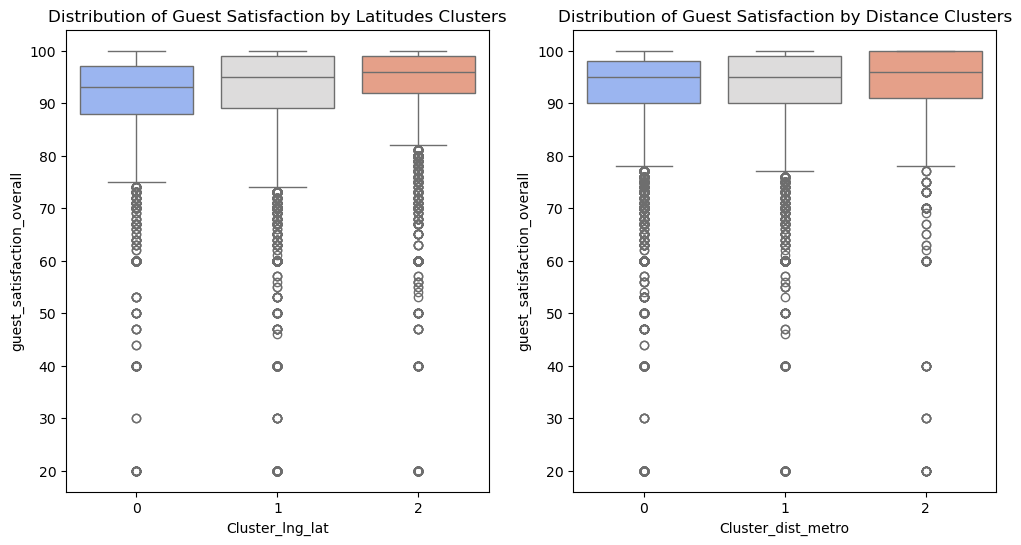

In [98]:
# Visualization info about clusters with boxplot
fig, axes = plt.subplots(1,2, figsize=(12,6))
sns.boxplot(data=df, x='Cluster_lng_lat', y='guest_satisfaction_overall', palette='coolwarm', ax=axes[0])
sns.boxplot(data=df, x='Cluster_dist_metro', y='guest_satisfaction_overall', palette='coolwarm', ax=axes[1])
axes[0].set_title('Distribution of Guest Satisfaction by Latitudes Clusters')
axes[1].set_title('Distribution of Guest Satisfaction by Distance Clusters')
plt.show();

<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Let's also check guest satisfaction by accommodation type.

In [100]:
# Creating a pivot table to calculate the mean of guest satisfaction based on latitude clusters and room type
satisfaction_room_lat = pd.pivot_table(
    df,
    index='Cluster_lng_lat',
    columns='room_type',
    values='guest_satisfaction_overall',
    aggfunc='mean'
)

# Creating a pivot table to calculate the mean of guest satisfaction based on distance clusters and room type
satisfaction_room_dist = pd.pivot_table(
    df,
    index='Cluster_dist_metro',
    columns='room_type',
    values='guest_satisfaction_overall',
    aggfunc='mean'
)

# Printing and displaying information about guest satisfaction with latitude  and distance clusters
print(f'Info about room type and guest satisfaction with the latitudes clusters:')
display(satisfaction_room_lat)
print(f'Info about room type and guest satisfaction with the distance clusters:')
display(satisfaction_room_dist)

Info about room type and guest satisfaction with the latitudes clusters:


room_type,Private room,Entire home/apt,Shared room
Cluster_lng_lat,,,
0,90.961,91.331,85.733
1,92.432,91.464,90.793
2,92.879,94.273,91.283


Info about room type and guest satisfaction with the distance clusters:


room_type,Private room,Entire home/apt,Shared room
Cluster_dist_metro,,,
0,91.772,93.109,89.636
1,92.720,92.261,90.380
2,93.254,92.983,86.087


<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Conclusion:
    
Latitude and Longitude Clusters (Cluster_lng_lat):</div>
<div style="color: #8B4513;font-size: 15px;">

Cluster 2, located in eastern or southeastern Europe (e.g., Budapest), shows the highest average guest satisfaction with the smallest variability. This indicates a more consistent experience for renters within this cluster. Most guests evaluate their stay similarly, suggesting that the quality of accommodations in this cluster is stable and reliable.

Cluster 1 has slightly lower average satisfaction than Cluster 2 and a moderate variability, pointing to generally good but somewhat inconsistent experiences.

Cluster 0 demonstrates the lowest average satisfaction and a wider range of guest ratings, indicating more diverse experiences, where some properties may lack quality.
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Distance to Metro and City Center Clusters (Cluster_dist_metro):</div>
<div style="color: #8B4513;font-size: 15px;">
Cluster 2, characterized by proximity to the metro but greater distance from the city center, has the highest average guest satisfaction but also the largest variability in ratings. This suggests that while many properties are highly rated, others fail to meet guest expectations.
For example, some properties may be located in modern areas with good infrastructure and receive high ratings, while others in the same cluster might be older or less convenient, leading to lower scores.

Cluster 1 shows good guest satisfaction with less variability, reflecting a more consistent level of quality across properties.

Cluster 0 has the lowest average satisfaction and the smallest variability, indicating that properties in this cluster generally deliver similar but lower-quality experiences.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Room Types:</div>
<div style="color: #8B4513; font-size: 15px;">

Across all clusters, "Entire home/apt" consistently receives the highest satisfaction ratings, highlighting the importance of privacy and autonomy for guests.
    
"Shared room" receives the lowest satisfaction ratings in every cluster, likely due to discomfort or limited amenities.

In Cluster 2 (both latitude/longitude and distance/metro), "Entire home/apt" achieves the highest scores (94.273 and 93.254, respectively), indicating that this property type strongly contributes to guest satisfaction in these areas.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">
Guest satisfaction is most strongly influenced by proximity to the metro rather than the city center. Locations with modern infrastructure and consistent service (e.g., Cluster 2) yield higher satisfaction, while areas with mixed property quality show greater variability in guest ratings.

Recommendations:

Improving Shared Rooms:</div>
<div style="color: #8B4513; font-size: 15px;">

Owners should invest in improving facilities such as amenities and design to increase satisfaction.</div>
<div style="color: #8B4513; font-weight: bold; font-size: 16px;">

Capitalizing on Cluster 2 strengths:</div>

<div style="color: #8B4513; font-size: 15px;">
For properties in Cluster 2, it is worth emphasizing the benefits of consistent service or improving facilities in the bottom quartile to reduce the spread of ratings.</div>

### Saving aggregated data 

In [102]:
# Save the hole dataset to a file
df.to_csv('arbnb_data_expanded_1.csv', index=True)
print('All data saved to "arbnb_data_expanded.csv"')

All data saved to "arbnb_data_expanded.csv"


<div style="font-weight: bold; font-size: 14px;">
    
### [LINK](https://public.tableau.com/shared/K2Y4TN7TH?:display_count=n&:origin=viz_share_link) to dashboard in Tableau Public 